## Setup

In [1]:
import numpy as np
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import gc
import io
from contextlib import redirect_stdout

from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from fastkde.fastKDE import fastKDE
from scipy.stats import linregress
from scipy.signal import butter, filtfilt
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.signal import find_peaks

from harp_resources import process, utils
from sleap import load_and_process as lp
from sleap import processing_functions as pf
from sleap import saccade_processing as sp
from sleap.saccade_processing import analyze_eye_video_saccades


def get_eye_label(key):
    """Return mapped user-viewable eye label for video key."""
    return VIDEO_LABELS.get(key, key)


# symbols to use ✅ ℹ️ ⚠️ ❗

In [2]:
# set up variables and load data 
############################################################################################################



# User-editable friendly labels for plotting and console output:

video1_eye = 'L'  # Options: 'L' or 'R'; which eye does VideoData1 represent? ('L' = Left, 'R' = Right)
plot_timeseries = False
score_cutoff = 0.2 # for filtering out inferred points with low confidence, they get interpolated 
outlier_sd_threshold = 10 # for removing outliers from the data, they get interpolated 
NaNs_removed = False # for checking if NaNs already removed in the notebook
cutoff = 10  # Hz for pupil diameter filtering 

# Parameters for blink detection
min_blink_duration_ms = 50  # minimum blink duration in milliseconds
max_blink_duration_ms = 500  # maximum blink duration in milliseconds
blink_merge_window_ms = 100  # merge blinks within this window (for double blinks) - shall this be longer? 

# for saccades
refractory_period = 0.1  # sec
## Separate adaptive saccade threshold (k) for each video:
k1 = 4  # for VideoData1 (L)
k2 = 5  # for VideoData2 (R)

# for adaptive saccade threshold - Number of standard deviations (adjustable: 2-4 range works well) 
onset_offset_fraction = 0.2  # to determine saccade onset and offset, i.e. o.2 is 20% of the peak velocity
n_before = 10  # Number of points before detection peak to extract for peri-saccade-segments, points, so independent of FPS 
n_after = 30   # Number of points after detection peak to extract

plot_saccade_detection_QC = True

video2_eye = 'R' if video1_eye == 'L' else 'L' # Automatically assign eye for VideoData2
eye_fullname = {'L': 'Left', 'R': 'Right'} # Map for full names (used in labels)
# Update VIDEO_LABELS based on selection
VIDEO_LABELS = {
    'VideoData1': f"VideoData1 ({video1_eye}: {eye_fullname[video1_eye]})",
    'VideoData2': f"VideoData2 ({video2_eye}: {eye_fullname[video2_eye]})"
}

data_path = Path('/Users/rancze/Documents/Data/vestVR/20250409_Cohort3_rotation/Visual_mismatch_day4/B6J2782-2025-04-28T14-22-03') 
#data_path = Path('/Users/rancze/Documents/Data/vestVR/Cohort1/No_iso_correction/Visual_mismatch_day3/B6J2717-2024-12-10T12-17-03') # only has sleap data 1
save_path = data_path.parent / f"{data_path.name}_processedData"

print ("\n❗ 20251025 NOT sure I understand this Ede ---- if SleapData.csv was already saved in the VideoData folder, this may break. Delete the file if you want to rerun processing\n")
VideoData1, VideoData2, VideoData1_Has_Sleap, VideoData2_Has_Sleap = lp.load_videography_data(data_path)

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

if VideoData1_Has_Sleap:
    VideoData1 = VideoData1.drop(columns=['track']) # drop the track column as it is empty
    coordinates_dict1_raw=lp.get_coordinates_dict(VideoData1, columns_of_interest)
    FPS_1 = 1 / VideoData1["Seconds"].diff().mean()  # frame rate for VideoData1 TODO where to save it, is it useful?
    print(f"{get_eye_label('VideoData1')}: FPS = {FPS_1}")

if VideoData2_Has_Sleap:
    VideoData2 = VideoData2.drop(columns=['track']) # drop the track column as it is empty
    coordinates_dict2_raw=lp.get_coordinates_dict(VideoData2, columns_of_interest)
    FPS_2 = 1 / VideoData2["Seconds"].diff().mean()  # frame rate for VideoData2
    print(f"{get_eye_label('VideoData2')}: FPS = {FPS_2}")


❗ 20251025 NOT sure I understand this Ede ---- if SleapData.csv was already saved in the VideoData folder, this may break. Delete the file if you want to rerun processing

ℹ️ Make sure the SLEAP files follow this convention: VideoData1_1904-01-01T00-00-00.sleap.csv

Outputs of SLEAP found in VideoData1: True
Outputs of SLEAP found in VideoData2: True
Found .csv VideoData logs timestamped at:
- 1904-01-04T23:00:00.000000000
- 1904-01-05T00:00:00.000000000
ℹ️ VideoData1 has 63 dropped frames. Filling missing frames with empty rows.
ℹ️ VideoData2 has 52 dropped frames. Filling missing frames with empty rows.
VideoData1 (L: Left): FPS = 59.56704791768507
VideoData2 (R: Right): FPS = 59.56705598182681


In [3]:
# plot timeseries of coordinates in browser for both VideoData1 and VideoData2
############################################################################################################
if plot_timeseries:
    print(f'⚠️ Check for long discontinuities and outliers in the data, we will try to deal with them later')
    print(f'ℹ️ Figures open in browser window, takes a bit of time.')

    # Helper list variables
    subplot_titles = (
        "X coordinates for pupil centre and left-right eye corner",
        "Y coordinates for pupil centre and left-right eye corner",
        "X coordinates for iris points",
        "Y coordinates for iris points"
    )
    eye_x = ['left.x', 'center.x', 'right.x']
    eye_y = ['left.y', 'center.y', 'right.y']
    iris_x = ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']
    iris_y = ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']

    # --- VideoData1 ---
    if VideoData1_Has_Sleap:
        fig1 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=subplot_titles
        )

        # Row 1: left.x, center.x, right.x
        for col in eye_x:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=1, col=1)
        # Row 2: left.y, center.y, right.y
        for col in eye_y:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=2, col=1)
        # Row 3: p1.x ... p8.x
        for col in iris_x:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=3, col=1)
        # Row 4: p1.y ... p8.y
        for col in iris_y:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=4, col=1)

        fig1.update_layout(
            height=1200,
            title_text=f"Time series subplots for coordinates [{get_eye_label('VideoData1')}]",
            showlegend=True
        )
        fig1.update_xaxes(title_text="Seconds", row=4, col=1)
        fig1.update_yaxes(title_text="X Position", row=1, col=1)
        fig1.update_yaxes(title_text="Y Position", row=2, col=1)
        fig1.update_yaxes(title_text="X Position", row=3, col=1)
        fig1.update_yaxes(title_text="Y Position", row=4, col=1)

        fig1.show(renderer='browser')

    # --- VideoData2 ---
    if VideoData2_Has_Sleap:
        fig2 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=subplot_titles
        )
        # Row 1: left.x, center.x, right.x
        for col in eye_x:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=1, col=1)
        # Row 2: left.y, center.y, right.y
        for col in eye_y:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=2, col=1)
        # Row 3: p1.x ... p8.x
        for col in iris_x:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=3, col=1)
        # Row 4: p1.y ... p8.y
        for col in iris_y:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=4, col=1)

        fig2.update_layout(
            height=1200,
            title_text=f"Time series subplots for coordinates [{get_eye_label('VideoData2')}]",
            showlegend=True
        )
        fig2.update_xaxes(title_text="Seconds", row=4, col=1)
        fig2.update_yaxes(title_text="X Position", row=1, col=1)
        fig2.update_yaxes(title_text="Y Position", row=2, col=1)
        fig2.update_yaxes(title_text="X Position", row=3, col=1)
        fig2.update_yaxes(title_text="Y Position", row=4, col=1)

        fig2.show(renderer='browser')

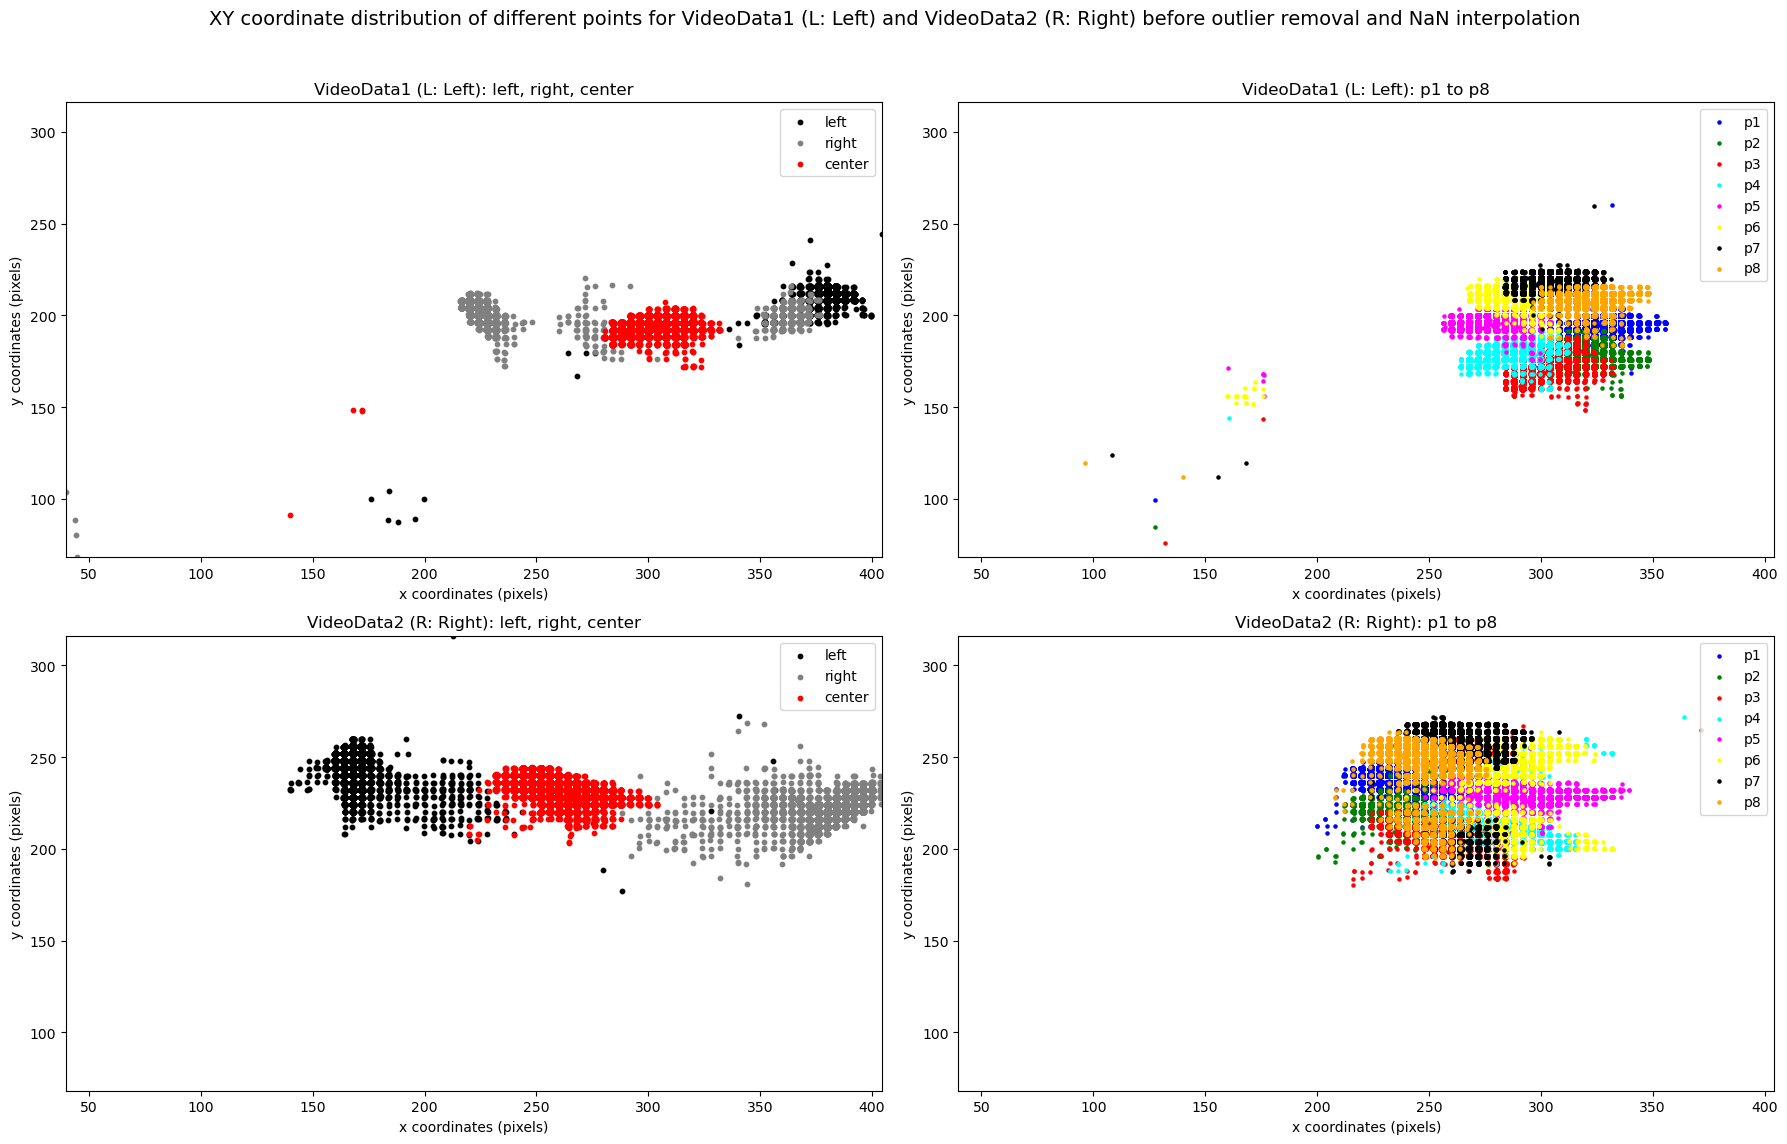

In [4]:
# QC plot XY coordinate distributions to visualize outliers 
############################################################################################################

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

# Filter out NaN values and calculate the min and max values for X and Y coordinates for both dict1 and dict2

def min_max_dict(coordinates_dict):
    x_min = min([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].min() for col in columns_of_interest])
    x_max = max([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].max() for col in columns_of_interest])
    y_min = min([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].min() for col in columns_of_interest])
    y_max = max([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].max() for col in columns_of_interest])
    return x_min, x_max, y_min, y_max

# Only plot panels for 1 and 2 if VideoData1_Has_Sleap and/or VideoData2_Has_Sleap are true

# Compute min/max as before for global axes limits
if VideoData1_Has_Sleap:
    x_min1, x_max1, y_min1, y_max1 = pf.min_max_dict(coordinates_dict1_raw, columns_of_interest)
if VideoData2_Has_Sleap:
    x_min2, x_max2, y_min2, y_max2 = pf.min_max_dict(coordinates_dict2_raw, columns_of_interest)

# Use global min and max for consistency only if both VideoData1_Has_Sleap and VideoData2_Has_Sleap are True
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    x_min = min(x_min1, x_min2)
    x_max = max(x_max1, x_max2)
    y_min = min(y_min1, y_min2)
    y_max = max(y_max1, y_max2)
elif VideoData1_Has_Sleap:
    x_min, x_max, y_min, y_max = x_min1, x_max1, y_min1, y_max1
elif VideoData2_Has_Sleap:
    x_min, x_max, y_min, y_max = x_min2, x_max2, y_min2, y_max2
else:
    raise ValueError("Neither VideoData1 nor VideoData2 has Sleap data available.")

# Create the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle(
    f"XY coordinate distribution of different points for {get_eye_label('VideoData1')} and {get_eye_label('VideoData2')} before outlier removal and NaN interpolation", 
    fontsize=14
)

# Define colormap for p1-p8
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

# Panel 1: left, right, center (dict1)
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    ax[0, 0].set_title(f"{get_eye_label('VideoData1')}: left, right, center")
    ax[0, 0].scatter(coordinates_dict1_raw['left.x'], coordinates_dict1_raw['left.y'], color='black', label='left', s=10)
    ax[0, 0].scatter(coordinates_dict1_raw['right.x'], coordinates_dict1_raw['right.y'], color='grey', label='right', s=10)
    ax[0, 0].scatter(coordinates_dict1_raw['center.x'], coordinates_dict1_raw['center.y'], color='red', label='center', s=10)
    ax[0, 0].set_xlim([x_min, x_max])
    ax[0, 0].set_ylim([y_min, y_max])
    ax[0, 0].set_xlabel('x coordinates (pixels)')
    ax[0, 0].set_ylabel('y coordinates (pixels)')
    ax[0, 0].legend(loc='upper right')
else:
    ax[0, 0].axis('off')

# Panel 2: p1 to p8 (dict1)
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    ax[0, 1].set_title(f"{get_eye_label('VideoData1')}: p1 to p8")
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[0, 1].scatter(coordinates_dict1_raw[f'{col}.x'], coordinates_dict1_raw[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[0, 1].set_xlim([x_min, x_max])
    ax[0, 1].set_ylim([y_min, y_max])
    ax[0, 1].set_xlabel('x coordinates (pixels)')
    ax[0, 1].set_ylabel('y coordinates (pixels)')
    ax[0, 1].legend(loc='upper right')
else:
    ax[0, 1].axis('off')

# Panel 3: left, right, center (dict2)
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    ax[1, 0].set_title(f"{get_eye_label('VideoData2')}: left, right, center")
    ax[1, 0].scatter(coordinates_dict2_raw['left.x'], coordinates_dict2_raw['left.y'], color='black', label='left', s=10)
    ax[1, 0].scatter(coordinates_dict2_raw['right.x'], coordinates_dict2_raw['right.y'], color='grey', label='right', s=10)
    ax[1, 0].scatter(coordinates_dict2_raw['center.x'], coordinates_dict2_raw['center.y'], color='red', label='center', s=10)
    ax[1, 0].set_xlim([x_min, x_max])
    ax[1, 0].set_ylim([y_min, y_max])
    ax[1, 0].set_xlabel('x coordinates (pixels)')
    ax[1, 0].set_ylabel('y coordinates (pixels)')
    ax[1, 0].legend(loc='upper right')
else:
    ax[1, 0].axis('off')

# Panel 4: p1 to p8 (dict2)
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    ax[1, 1].set_title(f"{get_eye_label('VideoData2')}: p1 to p8")
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[1, 1].scatter(coordinates_dict2_raw[f'{col}.x'], coordinates_dict2_raw[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[1, 1].set_xlim([x_min, x_max])
    ax[1, 1].set_ylim([y_min, y_max])
    ax[1, 1].set_xlabel('x coordinates (pixels)')
    ax[1, 1].set_ylabel('y coordinates (pixels)')
    ax[1, 1].legend(loc='upper right')
else:
    ax[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [5]:
# QC for consecutive NaN and low confidence inference frames TODO - not sure what to do, what threshold to use to send it back to SLEAP inference 
############################################################################################################
columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# VideoData1 NaN analysis
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    all_nan_df = VideoData1[VideoData1[columns_of_interest].isnull().all(1)]
    all_nan_index_array = all_nan_df.index.values

    # print the groups of sequential NaNs
    group_counts = {'1-5': 0, '6-10': 0, '>10': 0}
    i = 1
    for group in lp.find_sequential_groups(all_nan_index_array):
        #print(f'NaN frame group {i} with {len(group)} elements')
        if 1 <= len(group) <= 5:
            group_counts['1-5'] += 1
        elif 6 <= len(group) <= 10:
            group_counts['6-10'] += 1
        else:
            group_counts['>10'] += 1
            print(f'\n⚠️ VideoData1 Framegroup {i} has {len(group)} consecutive all NaN frames  with indices {group}. If this is a long group, consider rerunning SLEAP inference.')
        i += 1

    print(f"\nVideoData1 - Framegroups with 1-5 consecutive all NaN frames: {group_counts['1-5']}")
    print(f"VideoData1 - Framegroups with 6-10 consecutive all NaN frames: {group_counts['6-10']}")
    print(f"VideoData1 - Framegroups with >10 consecutive all NaN frames: {group_counts['>10']}")

# VideoData2 NaN analysis
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    all_nan_df2 = VideoData2[VideoData2[columns_of_interest].isnull().all(1)]
    all_nan_index_array2 = all_nan_df2.index.values

    # print the groups of sequential NaNs for VideoData2
    group_counts2 = {'1-5': 0, '6-10': 0, '>10': 0}
    i = 1
    for group in lp.find_sequential_groups(all_nan_index_array2):
        #print(f'NaN frame group {i} with {len(group)} elements')
        if 1 <= len(group) <= 5:
            group_counts2['1-5'] += 1
        elif 6 <= len(group) <= 10:
            group_counts2['6-10'] += 1
        else:
            group_counts2['>10'] += 1
            print(f'\n⚠️ VideoData2 Framegroup {i} has {len(group)} consecutive all NaN frames  with indices {group}. If this is a long group, consider rerunning SLEAP inference.')
        i += 1

    print(f"\nVideoData2 - Framegroups with 1-5 consecutive all NaN frames: {group_counts2['1-5']}")
    print(f"VideoData2 - Framegroups with 6-10 consecutive all NaN frames: {group_counts2['6-10']}")
    print(f"VideoData2 - Framegroups with >10 consecutive all NaN frames: {group_counts2['>10']}")

############################################################################################################
# check if we can use some filtering on scores to remove bad frames
############################################################################################################

columns_of_interest = ['left.score','center.score','right.score','p1.score','p2.score','p3.score','p4.score','p5.score','p6.score','p7.score','p8.score']

# VideoData1 confidence score analysis
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    total_points1 = len(VideoData1)
    print(f'\nℹ️ VideoData1 - Top 3 columns with most frames below {score_cutoff} confidence score:')

    # Calculate statistics for all columns
    video1_stats = []
    for col in columns_of_interest:
        count_below_threshold = (VideoData1[col] < score_cutoff).sum()
        percentage_below_threshold = (count_below_threshold / total_points1) * 100

        # Find the longest consecutive series below threshold
        below_threshold = VideoData1[col] < score_cutoff
        longest_series = 0
        current_series = 0

        for value in below_threshold:
            if value:
                current_series += 1
                if current_series > longest_series:
                    longest_series = current_series
            else:
                current_series = 0

        video1_stats.append((col, count_below_threshold, percentage_below_threshold, longest_series))

    # Sort by count_below_threshold and show top 3
    video1_stats.sort(key=lambda x: x[1], reverse=True)
    for i, (col, count, percentage, longest) in enumerate(video1_stats[:3]):
        print(f"VideoData1 - #{i+1}: {col} | Values below {score_cutoff}: {count} ({percentage:.2f}%) | Longest consecutive frame series: {longest}")

# VideoData2 confidence score analysis
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    total_points2 = len(VideoData2)
    print(f'\nℹ️ VideoData2 - Top 3 columns with most frames below {score_cutoff} confidence score:')

    # Calculate statistics for all columns
    video2_stats = []
    for col in columns_of_interest:
        count_below_threshold = (VideoData2[col] < score_cutoff).sum()
        percentage_below_threshold = (count_below_threshold / total_points2) * 100
        
        # Find the longest consecutive series below threshold
        below_threshold = VideoData2[col] < score_cutoff
        longest_series = 0
        current_series = 0
        
        for value in below_threshold:
            if value:
                current_series += 1
                if current_series > longest_series:
                    longest_series = current_series
            else:
                current_series = 0
        
        video2_stats.append((col, count_below_threshold, percentage_below_threshold, longest_series))

    # Sort by count_below_threshold and show top 3
    video2_stats.sort(key=lambda x: x[1], reverse=True)
    for i, (col, count, percentage, longest) in enumerate(video2_stats[:3]):
        print(f"VideoData2 - #{i+1}: {col} | Values below {score_cutoff}: {count} ({percentage:.2f}%) | Longest consecutive frame series: {longest}")


VideoData1 - Framegroups with 1-5 consecutive all NaN frames: 37
VideoData1 - Framegroups with 6-10 consecutive all NaN frames: 0
VideoData1 - Framegroups with >10 consecutive all NaN frames: 0

VideoData2 - Framegroups with 1-5 consecutive all NaN frames: 44
VideoData2 - Framegroups with 6-10 consecutive all NaN frames: 0
VideoData2 - Framegroups with >10 consecutive all NaN frames: 0

ℹ️ VideoData1 - Top 3 columns with most frames below 0.2 confidence score:
VideoData1 - #1: p7.score | Values below 0.2: 441 (0.38%) | Longest consecutive frame series: 36
VideoData1 - #2: p4.score | Values below 0.2: 405 (0.35%) | Longest consecutive frame series: 36
VideoData1 - #3: p1.score | Values below 0.2: 401 (0.35%) | Longest consecutive frame series: 36

ℹ️ VideoData2 - Top 3 columns with most frames below 0.2 confidence score:
VideoData2 - #1: p3.score | Values below 0.2: 858 (0.74%) | Longest consecutive frame series: 39
VideoData2 - #2: p4.score | Values below 0.2: 586 (0.51%) | Longest co

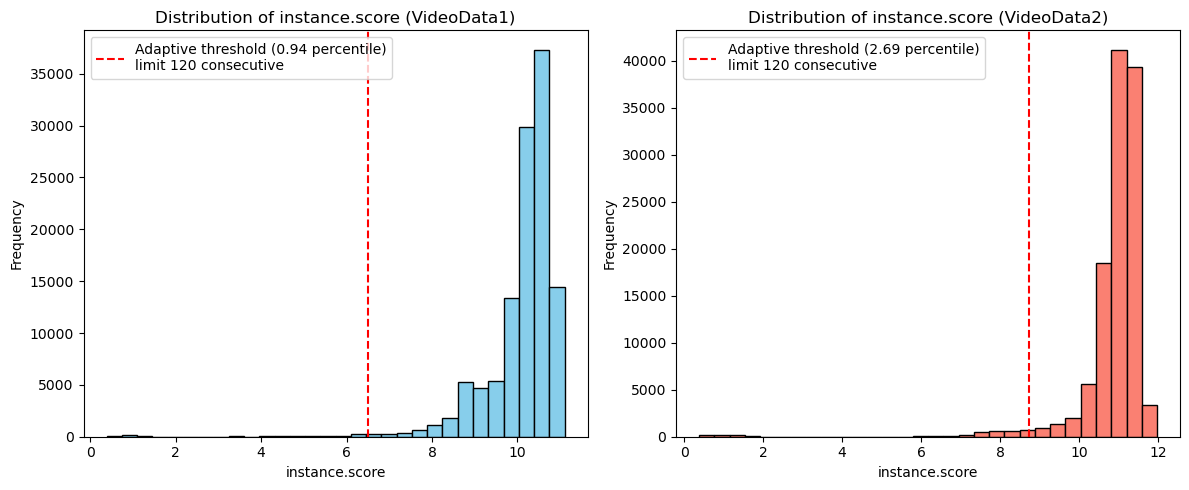


VideoData1: Total number of points with instance.score < adaptive threshold: 1087
VideoData2: Total number of points with instance.score < adaptive threshold: 3114

VideoData1: Top 5 longest consecutive sections where instance.score < adaptive threshold:
  Section 1: index 89349-89447 (length 99)
  Section 2: index 80169-80245 (length 77)
  Section 3: index 80053-80112 (length 60)
  Section 4: index 80122-80157 (length 36)
  Section 5: index 80290-80323 (length 34)

VideoData2: Top 5 longest consecutive sections where instance.score < adaptive threshold:
  Section 1: index 96230-96348 (length 119)
  Section 2: index 97466-97560 (length 95)
  Section 3: index 1201-1280 (length 80)
  Section 4: index 6740-6815 (length 76)
  Section 5: index 1448-1520 (length 73)


In [6]:
# Plotting the distribution of instance scores IN VIEW OF removing those as well! 
# Likely problem is that when instance score is low, that's because of a blink or similar, as there are long sequences of low scores
# which is perfeect to exclude and linearly interpolate (or keep it NaN?) -> but need to make sure it is really a blink an not model-issues 
# Now using an adaptive percentile threshold to ensure the maximum number of consecutively excluded frames <= max_consecutive_lowscore (default=6)

max_consecutive_lowscore = 120  # in frames TODO make it depend on FPS_1 and FPS_2 

# ---- User parameter: maximum allowed consecutive low-score frames ----

# Only analyze for dataset(s) that exist
has_v1 = "VideoData1_Has_Sleap" in globals() and VideoData1_Has_Sleap
has_v2 = "VideoData2_Has_Sleap" in globals() and VideoData2_Has_Sleap

fig = None
if has_v1 or has_v2:
    plt.figure(figsize=(12,5))
    plot_index = 1

# Find adaptive percentile and threshold for each present VideoData
if has_v1:
    adaptive_pct_v1, adaptive_thr_v1 = pf.find_percentile_for_consecutive_limit(VideoData1['instance.score'], max_consecutive_lowscore)
    plt.subplot(1, 2 if has_v2 else 1, plot_index)
    plt.hist(VideoData1['instance.score'].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.axvline(adaptive_thr_v1, color='red', linestyle='--', label=f'Adaptive threshold ({adaptive_pct_v1*100:.2f} percentile)\nlimit {max_consecutive_lowscore} consecutive')
    plt.title("Distribution of instance.score (VideoData1)")
    plt.xlabel("instance.score")
    plt.ylabel("Frequency")
    plt.legend()
    plot_index += 1

if has_v2:
    adaptive_pct_v2, adaptive_thr_v2 = pf.find_percentile_for_consecutive_limit(VideoData2['instance.score'], max_consecutive_lowscore)
    plt.subplot(1, 2 if has_v1 else 1, plot_index)
    plt.hist(VideoData2['instance.score'].dropna(), bins=30, color='salmon', edgecolor='black')
    plt.axvline(adaptive_thr_v2, color='red', linestyle='--', label=f'Adaptive threshold ({adaptive_pct_v2*100:.2f} percentile)\nlimit {max_consecutive_lowscore} consecutive')
    plt.title("Distribution of instance.score (VideoData2)")
    plt.xlabel("instance.score")
    plt.ylabel("Frequency")
    plt.legend()
    plot_index += 1

if has_v1 or has_v2:
    plt.tight_layout()
    plt.show()

# Report the statistics for available VideoData
if has_v1:
    v1_num_low = (VideoData1['instance.score'] < adaptive_thr_v1).sum()
    print(f"\nVideoData1: Total number of points with instance.score < adaptive threshold: {v1_num_low}")
if has_v2:
    v2_num_low = (VideoData2['instance.score'] < adaptive_thr_v2).sum()
    print(f"VideoData2: Total number of points with instance.score < adaptive threshold: {v2_num_low}")

# Report the top 5 longest consecutive sections with instance.score < adaptive threshold
if has_v1:
    print(f"\nVideoData1: Top 5 longest consecutive sections where instance.score < adaptive threshold:")
    low_sections_v1 = pf.find_longest_lowscore_sections(VideoData1['instance.score'], adaptive_thr_v1, top_n=5)
    for i, sec in enumerate(low_sections_v1, 1):
        start_idx = sec['start_idx']
        end_idx = sec['end_idx']
        start_time = VideoData1.index[start_idx] if isinstance(VideoData1.index, pd.DatetimeIndex) else start_idx
        end_time = VideoData1.index[end_idx] if isinstance(VideoData1.index, pd.DatetimeIndex) else end_idx
        print(f"  Section {i}: index {start_idx}-{end_idx} (length {sec['length']})")
if has_v2:
    print(f"\nVideoData2: Top 5 longest consecutive sections where instance.score < adaptive threshold:")
    low_sections_v2 = pf.find_longest_lowscore_sections(VideoData2['instance.score'], adaptive_thr_v2, top_n=5)
    for i, sec in enumerate(low_sections_v2, 1):
        start_idx = sec['start_idx']
        end_idx = sec['end_idx']
        start_time = VideoData2.index[start_idx] if isinstance(VideoData2.index, pd.DatetimeIndex) else start_idx
        end_time = VideoData2.index[end_idx] if isinstance(VideoData2.index, pd.DatetimeIndex) else end_idx
        print(f"  Section {i}: index {start_idx}-{end_idx} (length {sec['length']})")



In [7]:
# center coordinates on median pupil centre, removing outliers, low confidence points (fill these two NaNs by interpolation), then mark low instances as blinks and remove them - keep them NaN
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

print("=== Centering ===")
# VideoData1 processing
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    # Calculate the mean of the center x and y points
    mean_center_x1 = VideoData1['center.x'].median()
    mean_center_y1 = VideoData1['center.y'].median()

    print(f"{get_eye_label('VideoData1')} - Centering on median pupil centre: \nMean center.x: {mean_center_x1}, Mean center.y: {mean_center_y1}")

    # Translate the coordinates
    for col in columns_of_interest:
        if '.x' in col:
            VideoData1[col] = VideoData1[col] - mean_center_x1
        elif '.y' in col:
            VideoData1[col] = VideoData1[col] - mean_center_y1

    VideoData1_centered = VideoData1.copy()

# VideoData2 processing
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    # Calculate the mean of the center x and y points
    mean_center_x2 = VideoData2['center.x'].median()
    mean_center_y2 = VideoData2['center.y'].median()

    print(f"{get_eye_label('VideoData2')} - Centering on median pupil centre: \nMean center.x: {mean_center_x2}, Mean center.y: {mean_center_y2}")

    # Translate the coordinates
    for col in columns_of_interest:
        if '.x' in col:
            VideoData2[col] = VideoData2[col] - mean_center_x2
        elif '.y' in col:
            VideoData2[col] = VideoData2[col] - mean_center_y2

    VideoData2_centered = VideoData2.copy()

############################################################################################################
# remove low confidence points (score < threshold)
############################################################################################################
if not NaNs_removed:
    print("\n=== Score-based Filtering ===")
    print(f"Score threshold: {score_cutoff}")
    # List of point names (without .x, .y, .score)
    point_names = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

    # VideoData1 score-based filtering
    if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
        total_low_score1 = 0
        low_score_counts1 = {}
        for point in point_names:
            if f'{point}.score' in VideoData1.columns:
                # Find indices where score is below threshold
                low_score_mask = VideoData1[f'{point}.score'] < score_cutoff
                low_score_count = low_score_mask.sum()
                low_score_counts1[f'{point}.x'] = low_score_count
                low_score_counts1[f'{point}.y'] = low_score_count
                total_low_score1 += low_score_count * 2  # *2 because we're removing both x and y
                
                # Set x and y to NaN for low confidence points
                VideoData1.loc[low_score_mask, f'{point}.x'] = np.nan
                VideoData1.loc[low_score_mask, f'{point}.y'] = np.nan
        
        # Find the channel with the maximum number of low-score points
        max_low_score_channel1 = max(low_score_counts1, key=low_score_counts1.get)
        max_low_score_count1 = low_score_counts1[max_low_score_channel1]
        
        # Print the channel with the maximum number of low-score points
        print(f"{get_eye_label('VideoData1')} - Channel with the maximum number of low-confidence points: {max_low_score_channel1}, Number of low-confidence points: {max_low_score_count1}")
        print(f"{get_eye_label('VideoData1')} - A total number of {total_low_score1} low-confidence coordinate values were replaced by interpolation")

    # VideoData2 score-based filtering
    if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
        total_low_score2 = 0
        low_score_counts2 = {}
        for point in point_names:
            if f'{point}.score' in VideoData2.columns:
                # Find indices where score is below threshold
                low_score_mask = VideoData2[f'{point}.score'] < score_cutoff
                low_score_count = low_score_mask.sum()
                low_score_counts2[f'{point}.x'] = low_score_count
                low_score_counts2[f'{point}.y'] = low_score_count
                total_low_score2 += low_score_count * 2  # *2 because we're removing both x and y
                
                # Set x and y to NaN for low confidence points
                VideoData2.loc[low_score_mask, f'{point}.x'] = np.nan
                VideoData2.loc[low_score_mask, f'{point}.y'] = np.nan
        
        # Find the channel with the maximum number of low-score points
        max_low_score_channel2 = max(low_score_counts2, key=low_score_counts2.get)
        max_low_score_count2 = low_score_counts2[max_low_score_channel2]
        
        # Print the channel with the maximum number of low-score points
        print(f"{get_eye_label('VideoData2')} - Channel with the maximum number of low-confidence points: {max_low_score_channel2}, Number of low-confidence points: {max_low_score_count2}")
        print(f"{get_eye_label('VideoData2')} - A total number of {total_low_score2} low-confidence coordinate values were replaced by interpolation")

    ############################################################################################################
    # remove outliers (x times SD)
    # then interpolates on all NaN values (skipped frames, low confidence inference points, outliers)
    ############################################################################################################

    print("\n=== Outlier Analysis ===")

    # VideoData1 outlier analysis and interpolation
    if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
        # Calculate the standard deviation for each column of interest
        std_devs1 = {col: VideoData1[col].std() for col in columns_of_interest}

        # Calculate the number of outliers for each column
        outliers1 = {col: ((VideoData1[col] - VideoData1[col].mean()).abs() > outlier_sd_threshold * std_devs1[col]).sum() for col in columns_of_interest}

        # Find the channel with the maximum number of outliers
        max_outliers_channel1 = max(outliers1, key=outliers1.get)
        max_outliers_count1 = outliers1[max_outliers_channel1]

        # Print the channel with the maximum number of outliers and the number
        print(f"{get_eye_label('VideoData1')} - Channel with the maximum number of outliers: {max_outliers_channel1}, Number of outliers: {max_outliers_count1}")

        # Print the total number of outliers
        total_outliers1 = sum(outliers1.values())
        print(f"{get_eye_label('VideoData1')} - A total number of {total_outliers1} outliers were replaced by interpolation")

        # Replace outliers by interpolating between the previous and subsequent non-NaN value
        for col in columns_of_interest:
            outlier_indices = VideoData1[((VideoData1[col] - VideoData1[col].mean()).abs() > outlier_sd_threshold * std_devs1[col])].index
            VideoData1.loc[outlier_indices, col] = np.nan

        #VideoData1.interpolate(inplace=True)
        VideoData1 = VideoData1.interpolate(method='linear', limit_direction='both')

    # VideoData2 outlier analysis and interpolation
    if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
        # Calculate the standard deviation for each column of interest
        std_devs2 = {col: VideoData2[col].std() for col in columns_of_interest}

        # Calculate the number of outliers for each column
        outliers2 = {col: ((VideoData2[col] - VideoData2[col].mean()).abs() > outlier_sd_threshold * std_devs2[col]).sum() for col in columns_of_interest}

        # Find the channel with the maximum number of outliers
        max_outliers_channel2 = max(outliers2, key=outliers2.get)
        max_outliers_count2 = outliers2[max_outliers_channel2]

        # Print the channel with the maximum number of outliers and the number
        print(f"{get_eye_label('VideoData2')} - Channel with the maximum number of outliers: {max_outliers_channel2}, Number of outliers: {max_outliers_count2}")

        # Print the total number of outliers
        total_outliers2 = sum(outliers2.values())
        print(f"{get_eye_label('VideoData2')} - A total number of {total_outliers2} outliers were replaced by interpolation")

        # Replace outliers by interpolating between the previous and subsequent non-NaN value
        for col in columns_of_interest:
            outlier_indices = VideoData2[((VideoData2[col] - VideoData2[col].mean()).abs() > outlier_sd_threshold * std_devs2[col])].index
            VideoData2.loc[outlier_indices, col] = np.nan

        #VideoData2.interpolate(inplace=True)
        VideoData2 = VideoData2.interpolate(method='linear', limit_direction='both')

    # Set flag after both VideoData1 and VideoData2 processing is complete
    NaNs_removed = True
else:
    print("=== Interpolation already done, skipping ===")



=== Centering ===
VideoData1 (L: Left) - Centering on median pupil centre: 
Mean center.x: 304.25169372558594, Mean center.y: 195.6934967041016
VideoData2 (R: Right) - Centering on median pupil centre: 
Mean center.x: 264.44810485839844, Mean center.y: 231.88140869140625

=== Score-based Filtering ===
Score threshold: 0.2
VideoData1 (L: Left) - Channel with the maximum number of low-confidence points: p7.x, Number of low-confidence points: 441
VideoData1 (L: Left) - A total number of 7492 low-confidence coordinate values were replaced by interpolation
VideoData2 (R: Right) - Channel with the maximum number of low-confidence points: p3.x, Number of low-confidence points: 858
VideoData2 (R: Right) - A total number of 10472 low-confidence coordinate values were replaced by interpolation

=== Outlier Analysis ===
VideoData1 (L: Left) - Channel with the maximum number of outliers: right.x, Number of outliers: 343
VideoData1 (L: Left) - A total number of 500 outliers were replaced by interpo

In [8]:
# Blink detection using instance.score - mark blinks and set coordinates to NaN (keep them as NaN, no interpolation)
############################################################################################################

# Capture all print output to save to file

class TeeOutput:
    """Output to both stdout and a string buffer"""
    def __init__(self, stdout, buffer):
        self.stdout = stdout
        self.buffer = buffer
    
    def write(self, s):
        self.stdout.write(s)
        self.buffer.write(s)
    
    def flush(self):
        self.stdout.flush()
        self.buffer.flush()

output_buffer = io.StringIO()
original_stdout = sys.stdout
sys.stdout = TeeOutput(original_stdout, output_buffer)

# Run blink detection code with output captured
print("\n=== Blink Detection ===")

# VideoData1 blink detection
if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
    print(f"\n{get_eye_label('VideoData1')} - Blink Detection")
    
    # Calculate frame-based durations (using FPS_1 if available, otherwise estimate)
    if 'FPS_1' in globals():
        fps_1 = FPS_1
    else:
        fps_1 = 1 / VideoData1["Seconds"].diff().mean()
    
    # Use np.ceil to ensure minimum duration is always met (round up to ensure >= min duration)
    min_blink_frames = max(1, int(np.ceil(min_blink_duration_ms / 1000 * fps_1)))
    max_blink_frames = int(max_blink_duration_ms / 1000 * fps_1)
    merge_window_frames = int(blink_merge_window_ms / 1000 * fps_1)
    
    print(f"  FPS: {fps_1:.2f}")
    print(f"  Min blink duration: {min_blink_frames} frames ({min_blink_duration_ms}ms)")
    print(f"  Max blink duration: {max_blink_frames} frames ({max_blink_duration_ms}ms)")
    print(f"  Merge window: {merge_window_frames} frames ({blink_merge_window_ms}ms)")
    
    # Use adaptive threshold from cell 6 if available, otherwise use percentile
    if 'adaptive_thr_v1' in globals():
        blink_threshold_v1 = adaptive_thr_v1
        print(f"  Using adaptive threshold: {blink_threshold_v1:.4f} (from cell 6)")
    else:
        # Calculate 10th percentile as fallback
        blink_threshold_v1 = VideoData1['instance.score'].quantile(0.10)
        print(f"  Using 10th percentile threshold: {blink_threshold_v1:.4f}")
    
    # Find blink segments
    blink_segments_v1 = pf.find_blink_segments(
        VideoData1['instance.score'], 
        blink_threshold_v1, 
        min_blink_frames, 
        max_blink_frames
    )
    
    # Merge nearby blinks
    blink_segments_v1 = pf.merge_nearby_blinks(blink_segments_v1, merge_window_frames)
    
    # Post-merge filter: Remove segments that don't meet minimum duration in actual milliseconds
    # (because merging might create segments that are still too short)
    filtered_blinks_v1 = []
    for blink in blink_segments_v1:
        start_idx = blink['start_idx']
        end_idx = blink['end_idx']
        start_time = VideoData1['Seconds'].iloc[start_idx]
        end_time = VideoData1['Seconds'].iloc[end_idx]
        duration_ms = (end_time - start_time) * 1000
        
        # Only keep if duration meets minimum and maximum requirements
        if min_blink_duration_ms <= duration_ms <= max_blink_duration_ms:
            filtered_blinks_v1.append(blink)
        # else: skip this blink (it doesn't meet duration requirements)
    blink_segments_v1 = filtered_blinks_v1
    
    print(f"  Detected {len(blink_segments_v1)} blink segment(s)")
    
    if len(blink_segments_v1) > 0:
        # Get start time of recording (for calculating time from beginning)
        recording_start_time = VideoData1['Seconds'].iloc[0]
        
        # Mark blinks by setting coordinates to NaN
        total_blink_frames_v1 = 0
        for i, blink in enumerate(blink_segments_v1, 1):
            start_idx = blink['start_idx']
            end_idx = blink['end_idx']
            VideoData1.loc[VideoData1.index[start_idx:end_idx+1], columns_of_interest] = np.nan
            total_blink_frames_v1 += blink['length']
            
            # Calculate time range
            start_time = VideoData1['Seconds'].iloc[start_idx]
            end_time = VideoData1['Seconds'].iloc[end_idx]
            duration_ms = (end_time - start_time) * 1000
            
            # Calculate time from start of recording
            start_time_from_start = start_time - recording_start_time
            end_time_from_start = end_time - recording_start_time
            
            # Format times as MM:SS
            start_time_str = pf.format_time_from_start(start_time_from_start)
            end_time_str = pf.format_time_from_start(end_time_from_start)
            
            # Get actual frame numbers from frame_idx column (for video frame correspondence)
            # If frame_idx doesn't exist, fall back to pandas index positions
            if 'frame_idx' in VideoData1.columns:
                actual_start_frame = int(VideoData1['frame_idx'].iloc[start_idx])
                actual_end_frame = int(VideoData1['frame_idx'].iloc[end_idx])
                frame_info = f"frames {actual_start_frame}-{actual_end_frame} (pandas idx {start_idx}-{end_idx})"
            else:
                # Fallback: use pandas index if frame_idx column doesn't exist
                actual_start_frame = start_idx
                actual_end_frame = end_idx
                frame_info = f"frames {actual_start_frame}-{actual_end_frame}"
            
            print(f"    Blink {i}: {frame_info}, {blink['length']} frames, "
                  f"{duration_ms:.1f}ms) at {start_time_str}-{end_time_str}, "
                  f"mean score: {blink['mean_score']:.4f}")
        
        print(f"  Total blink frames marked: {total_blink_frames_v1} frames "
              f"({total_blink_frames_v1/fps_1*1000:.1f}ms)")
        
        # Calculate blink rate
        recording_duration_min = (VideoData1['Seconds'].iloc[-1] - VideoData1['Seconds'].iloc[0]) / 60
        blink_rate = len(blink_segments_v1) / recording_duration_min if recording_duration_min > 0 else 0
        print(f"  Blink rate: {blink_rate:.2f} blinks/minute")
    else:
        print("  No blinks detected")

# VideoData2 blink detection
if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
    print(f"\n{get_eye_label('VideoData2')} - Blink Detection")
    
    # Calculate frame-based durations (using FPS_2 if available, otherwise estimate)
    if 'FPS_2' in globals():
        fps_2 = FPS_2
    else:
        fps_2 = 1 / VideoData2["Seconds"].diff().mean()
    
    # Use np.ceil to ensure minimum duration is always met (round up to ensure >= min duration)
    min_blink_frames = max(1, int(np.ceil(min_blink_duration_ms / 1000 * fps_2)))
    max_blink_frames = int(max_blink_duration_ms / 1000 * fps_2)
    merge_window_frames = int(blink_merge_window_ms / 1000 * fps_2)
    
    print(f"  FPS: {fps_2:.2f}")
    print(f"  Min blink duration: {min_blink_frames} frames ({min_blink_duration_ms}ms)")
    print(f"  Max blink duration: {max_blink_frames} frames ({max_blink_duration_ms}ms)")
    print(f"  Merge window: {merge_window_frames} frames ({blink_merge_window_ms}ms)")
    
    # Use adaptive threshold from cell 6 if available, otherwise use percentile
    if 'adaptive_thr_v2' in globals():
        blink_threshold_v2 = adaptive_thr_v2
        print(f"  Using adaptive threshold: {blink_threshold_v2:.4f} (from cell 6)")
    else:
        # Calculate 10th percentile as fallback
        blink_threshold_v2 = VideoData2['instance.score'].quantile(0.10)
        print(f"  Using 10th percentile threshold: {blink_threshold_v2:.4f}")
    
    # Find blink segments
    blink_segments_v2 = pf.find_blink_segments(
        VideoData2['instance.score'], 
        blink_threshold_v2, 
        min_blink_frames, 
        max_blink_frames
    )
    
    # Merge nearby blinks
    blink_segments_v2 = pf.merge_nearby_blinks(blink_segments_v2, merge_window_frames)
    
    # Post-merge filter: Remove segments that don't meet minimum duration in actual milliseconds
    # (because merging might create segments that are still too short)
    filtered_blinks_v2 = []
    for blink in blink_segments_v2:
        start_idx = blink['start_idx']
        end_idx = blink['end_idx']
        start_time = VideoData2['Seconds'].iloc[start_idx]
        end_time = VideoData2['Seconds'].iloc[end_idx]
        duration_ms = (end_time - start_time) * 1000
        
        # Only keep if duration meets minimum and maximum requirements
        if min_blink_duration_ms <= duration_ms <= max_blink_duration_ms:
            filtered_blinks_v2.append(blink)
        # else: skip this blink (it doesn't meet duration requirements)
    blink_segments_v2 = filtered_blinks_v2
    
    print(f"  Detected {len(blink_segments_v2)} blink segment(s)")
    
    if len(blink_segments_v2) > 0:
        # Get start time of recording (for calculating time from beginning)
        recording_start_time = VideoData2['Seconds'].iloc[0]
        
        # Mark blinks by setting coordinates to NaN
        total_blink_frames_v2 = 0
        for i, blink in enumerate(blink_segments_v2, 1):
            start_idx = blink['start_idx']
            end_idx = blink['end_idx']
            VideoData2.loc[VideoData2.index[start_idx:end_idx+1], columns_of_interest] = np.nan
            total_blink_frames_v2 += blink['length']
            
            # Calculate time range
            start_time = VideoData2['Seconds'].iloc[start_idx]
            end_time = VideoData2['Seconds'].iloc[end_idx]
            duration_ms = (end_time - start_time) * 1000
            
            # Calculate time from start of recording
            start_time_from_start = start_time - recording_start_time
            end_time_from_start = end_time - recording_start_time
            
            # Format times as MM:SS
            start_time_str = pf.format_time_from_start(start_time_from_start)
            end_time_str = pf.format_time_from_start(end_time_from_start)
            
            # Get actual frame numbers from frame_idx column (for video frame correspondence)
            # If frame_idx doesn't exist, fall back to pandas index positions
            if 'frame_idx' in VideoData2.columns:
                actual_start_frame = int(VideoData2['frame_idx'].iloc[start_idx])
                actual_end_frame = int(VideoData2['frame_idx'].iloc[end_idx])
                frame_info = f"frames {actual_start_frame}-{actual_end_frame} (pandas idx {start_idx}-{end_idx})"
            else:
                # Fallback: use pandas index if frame_idx column doesn't exist
                actual_start_frame = start_idx
                actual_end_frame = end_idx
                frame_info = f"frames {actual_start_frame}-{actual_end_frame}"
            
            print(f"    Blink {i}: {frame_info}, {blink['length']} frames, "
                  f"{duration_ms:.1f}ms) at {start_time_str}-{end_time_str}, "
                  f"mean score: {blink['mean_score']:.4f}")
        
        print(f"  Total blink frames marked: {total_blink_frames_v2} frames "
              f"({total_blink_frames_v2/fps_2*1000:.1f}ms)")
        
        # Calculate blink rate
        recording_duration_min = (VideoData2['Seconds'].iloc[-1] - VideoData2['Seconds'].iloc[0]) / 60
        blink_rate = len(blink_segments_v2) / recording_duration_min if recording_duration_min > 0 else 0
        print(f"  Blink rate: {blink_rate:.2f} blinks/minute")
    else:
        print("  No blinks detected")

print("\n✅ Blink detection complete. Blink periods remain as NaN (not interpolated).")

# Restore original stdout and save captured output to file
sys.stdout = original_stdout

# Get the captured output
captured_output = output_buffer.getvalue()

# Save to file in data_path folder
output_file = data_path / "blink_detection_QC.txt"
output_file.parent.mkdir(parents=True, exist_ok=True)
with open(output_file, 'w') as f:
    f.write(captured_output)

print(f"\n✅ Blink detection output saved to: {output_file}")




=== Blink Detection ===

VideoData1 (L: Left) - Blink Detection
  FPS: 59.57
  Min blink duration: 3 frames (50ms)
  Max blink duration: 29 frames (500ms)
  Merge window: 5 frames (100ms)
  Using adaptive threshold: 6.4974 (from cell 6)
  Detected 29 blink segment(s)
    Blink 1: frames 2659-2676 (pandas idx 2659-2676), 18 frames, 283.3ms) at 0:58-0:58, mean score: 4.0210
    Blink 2: frames 6393-6397 (pandas idx 6393-6397), 5 frames, 66.7ms) at 2:00-2:00, mean score: 5.9630
    Blink 3: frames 6490-6509 (pandas idx 6490-6509), 20 frames, 316.7ms) at 2:02-2:02, mean score: 1.2919
    Blink 4: frames 19411-19422 (pandas idx 19411-19422), 12 frames, 183.3ms) at 5:37-5:37, mean score: 7.0796
    Blink 5: frames 27926-27950 (pandas idx 27926-27950), 25 frames, 400.0ms) at 7:59-7:59, mean score: 9.6916
    Blink 6: frames 27957-27964 (pandas idx 27957-27964), 8 frames, 116.7ms) at 8:00-8:00, mean score: 4.8583
    Blink 7: frames 27971-27975 (pandas idx 27971-27975), 5 frames, 66.7ms) at 8

In [ ]:
# QC plot timeseries of interpolation corrected NaN and (TODO low confidence coordinates in browser 
############################################################################################################

if plot_timeseries:
    print(f'ℹ️ Figure opens in browser window, takes a bit of time.')
    
    # VideoData1 QC Plot
    if 'VideoData1_Has_Sleap' in globals() and VideoData1_Has_Sleap:
        fig1 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=(
                f"VideoData1 - X coordinates for pupil centre and left-right eye corner",
                f"VideoData1 - Y coordinates for pupil centre and left-right eye corner",
                f"VideoData1 - X coordinates for iris points",
                f"VideoData1 - Y coordinates for iris points"
            )
        )

        # Row 1: Plot left.x, center.x, right.x
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.x'], mode='lines', name='left.x'), row=1, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.x'], mode='lines', name='center.x'), row=1, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.x'], mode='lines', name='right.x'), row=1, col=1)

        # Row 2: Plot left.y, center.y, right.y
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['left.y'], mode='lines', name='left.y'), row=2, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['center.y'], mode='lines', name='center.y'), row=2, col=1)
        fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1['right.y'], mode='lines', name='right.y'), row=2, col=1)

        # Row 3: Plot p.x coordinates for p1 to p8
        for col in ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=3, col=1)

        # Row 4: Plot p.y coordinates for p1 to p8
        for col in ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']:
            fig1.add_trace(go.Scatter(x=VideoData1['Seconds'], y=VideoData1[col], mode='lines', name=col), row=4, col=1)

        fig1.update_layout(
            height=1200,
            title_text=f"VideoData1 - Time series subplots for coordinates (QC after interpolation)",
            showlegend=True
        )
        fig1.update_xaxes(title_text="Seconds", row=4, col=1)
        fig1.update_yaxes(title_text="X Position", row=1, col=1)
        fig1.update_yaxes(title_text="Y Position", row=2, col=1)
        fig1.update_yaxes(title_text="X Position", row=3, col=1)
        fig1.update_yaxes(title_text="Y Position", row=4, col=1)

        fig1.show(renderer='browser')
    
    # VideoData2 QC Plot
    if 'VideoData2_Has_Sleap' in globals() and VideoData2_Has_Sleap:
        fig2 = make_subplots(
            rows=4, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=(
                f"VideoData2 - X coordinates for pupil centre and left-right eye corner",
                f"VideoData2 - Y coordinates for pupil centre and left-right eye corner",
                f"VideoData2 - X coordinates for iris points",
                f"VideoData2 - Y coordinates for iris points"
            )
        )

        # Row 1: Plot left.x, center.x, right.x
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['left.x'], mode='lines', name='left.x'), row=1, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['center.x'], mode='lines', name='center.x'), row=1, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['right.x'], mode='lines', name='right.x'), row=1, col=1)

        # Row 2: Plot left.y, center.y, right.y
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['left.y'], mode='lines', name='left.y'), row=2, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['center.y'], mode='lines', name='center.y'), row=2, col=1)
        fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2['right.y'], mode='lines', name='right.y'), row=2, col=1)

        # Row 3: Plot p.x coordinates for p1 to p8
        for col in ['p1.x', 'p2.x', 'p3.x', 'p4.x', 'p5.x', 'p6.x', 'p7.x', 'p8.x']:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=3, col=1)

        # Row 4: Plot p.y coordinates for p1 to p8
        for col in ['p1.y', 'p2.y', 'p3.y', 'p4.y', 'p5.y', 'p6.y', 'p7.y', 'p8.y']:
            fig2.add_trace(go.Scatter(x=VideoData2['Seconds'], y=VideoData2[col], mode='lines', name=col), row=4, col=1)

        fig2.update_layout(
            height=1200,
            title_text=f"VideoData2 - Time series subplots for coordinates (QC after interpolation)",
            showlegend=True
        )
        fig2.update_xaxes(title_text="Seconds", row=4, col=1)
        fig2.update_yaxes(title_text="X Position", row=1, col=1)
        fig2.update_yaxes(title_text="Y Position", row=2, col=1)
        fig2.update_yaxes(title_text="X Position", row=3, col=1)
        fig2.update_yaxes(title_text="Y Position", row=4, col=1)

        fig2.show(renderer='browser')

In [ ]:
# QC plot XY coordinate distributions after NaN and ( TODO - low confidence inference points) are interpolated 
##############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# Create coordinates_dict for both datasets
if VideoData1_Has_Sleap:
    coordinates_dict1_processed = lp.get_coordinates_dict(VideoData1, columns_of_interest)
if VideoData2_Has_Sleap:
    coordinates_dict2_processed = lp.get_coordinates_dict(VideoData2, columns_of_interest)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

# Filter out NaN values and calculate the min and max values for X and Y coordinates for both dict1 and dict2
def min_max_dict(coordinates_dict):
    x_min = min([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].min() for col in columns_of_interest])
    x_max = max([coordinates_dict[f'{col}.x'][~np.isnan(coordinates_dict[f'{col}.x'])].max() for col in columns_of_interest])
    y_min = min([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].min() for col in columns_of_interest])
    y_max = max([coordinates_dict[f'{col}.y'][~np.isnan(coordinates_dict[f'{col}.y'])].max() for col in columns_of_interest])
    return x_min, x_max, y_min, y_max

if VideoData1_Has_Sleap:
    x_min1, x_max1, y_min1, y_max1 = min_max_dict(coordinates_dict1_processed)
if VideoData2_Has_Sleap:
    x_min2, x_max2, y_min2, y_max2 = min_max_dict(coordinates_dict2_processed)

# Use global min and max for consistency across subplots
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    x_min = min(x_min1, x_min2)
    x_max = max(x_max1, x_max2)
    y_min = min(y_min1, y_min2)
    y_max = max(y_max1, y_max2)
elif VideoData1_Has_Sleap:
    x_min, x_max, y_min, y_max = x_min1, x_max1, y_min1, y_max1
elif VideoData2_Has_Sleap:
    x_min, x_max, y_min, y_max = x_min2, x_max2, y_min2, y_max2

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle(
    f"XY coordinate distribution of different points for {get_eye_label('VideoData1')} and {get_eye_label('VideoData2')} post outlier removal and NaN interpolation",
    fontsize=14
)

# Define colormap for p1-p8
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

# Panel 1: left, right, center (VideoData1)
if VideoData1_Has_Sleap:
    ax[0, 0].set_title(f"{get_eye_label('VideoData1')}: left, right, center")
    ax[0, 0].scatter(coordinates_dict1_processed['left.x'], coordinates_dict1_processed['left.y'], color='black', label='left', s=10)
    ax[0, 0].scatter(coordinates_dict1_processed['right.x'], coordinates_dict1_processed['right.y'], color='grey', label='right', s=10)
    ax[0, 0].scatter(coordinates_dict1_processed['center.x'], coordinates_dict1_processed['center.y'], color='red', label='center', s=10)
    ax[0, 0].set_xlim([x_min, x_max])
    ax[0, 0].set_ylim([y_min, y_max])
    ax[0, 0].set_xlabel('x coordinates (pixels)')
    ax[0, 0].set_ylabel('y coordinates (pixels)')
    ax[0, 0].legend(loc='upper right')

    # Panel 2: p1 to p8 (VideoData1)
    ax[0, 1].set_title(f"{get_eye_label('VideoData1')}: p1 to p8")
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[0, 1].scatter(coordinates_dict1_processed[f'{col}.x'], coordinates_dict1_processed[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[0, 1].set_xlim([x_min, x_max])
    ax[0, 1].set_ylim([y_min, y_max])
    ax[0, 1].set_xlabel('x coordinates (pixels)')
    ax[0, 1].set_ylabel('y coordinates (pixels)')
    ax[0, 1].legend(loc='upper right')

# Panel 3: left, right, center (VideoData2)
if VideoData2_Has_Sleap:
    ax[1, 0].set_title(f"{get_eye_label('VideoData2')}: left, right, center")
    ax[1, 0].scatter(coordinates_dict2_processed['left.x'], coordinates_dict2_processed['left.y'], color='black', label='left', s=10)
    ax[1, 0].scatter(coordinates_dict2_processed['right.x'], coordinates_dict2_processed['right.y'], color='grey', label='right', s=10)
    ax[1, 0].scatter(coordinates_dict2_processed['center.x'], coordinates_dict2_processed['center.y'], color='red', label='center', s=10)
    ax[1, 0].set_xlim([x_min, x_max])
    ax[1, 0].set_ylim([y_min, y_max])
    ax[1, 0].set_xlabel('x coordinates (pixels)')
    ax[1, 0].set_ylabel('y coordinates (pixels)')
    ax[1, 0].legend(loc='upper right')

    # Panel 4: p1 to p8 (VideoData2)
    ax[1, 1].set_title(f"{get_eye_label('VideoData2')}: p1 to p8")
    for idx, col in enumerate(columns_of_interest[3:]):
        ax[1, 1].scatter(coordinates_dict2_processed[f'{col}.x'], coordinates_dict2_processed[f'{col}.y'], color=colors[idx], label=col, s=5)
    ax[1, 1].set_xlim([x_min, x_max])
    ax[1, 1].set_ylim([y_min, y_max])
    ax[1, 1].set_xlabel('x coordinates (pixels)')
    ax[1, 1].set_ylabel('y coordinates (pixels)')
    ax[1, 1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [ ]:
# fit ellipses on the 8 points to determine pupil centre and diameter
############################################################################################################

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']

# VideoData1 processing
if VideoData1_Has_Sleap:
    print(f"=== VideoData1 Ellipse Fitting for Pupil Diameter ===")
    coordinates_dict1_processed = lp.get_coordinates_dict(VideoData1, columns_of_interest)

    theta1 = lp.find_horizontal_axis_angle(VideoData1, 'left', 'center')
    center_point1 = lp.get_left_right_center_point(coordinates_dict1_processed)

    columns_of_interest_reformatted = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    remformatted_coordinates_dict1 = lp.get_reformatted_coordinates_dict(coordinates_dict1_processed, columns_of_interest_reformatted)
    centered_coordinates_dict1 = lp.get_centered_coordinates_dict(remformatted_coordinates_dict1, center_point1)
    rotated_coordinates_dict1 = lp.get_rotated_coordinates_dict(centered_coordinates_dict1, theta1)

    columns_of_interest_ellipse = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    ellipse_parameters_data1, ellipse_center_points_data1 = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict1, columns_of_interest_ellipse)

    average_diameter1 = np.mean([ellipse_parameters_data1[:,0], ellipse_parameters_data1[:,1]], axis=0)

    SleapVideoData1 = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData1['Seconds'].values, average_diameter1, ellipse_parameters_data1[:,2], ellipse_center_points_data1[:,0], ellipse_center_points_data1[:,1]])

# VideoData2 processing
if VideoData2_Has_Sleap:
    print(f"=== VideoData2 Ellipse Fitting for Pupil Diameter ===")
    coordinates_dict2_processed = lp.get_coordinates_dict(VideoData2, columns_of_interest)

    theta2 = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
    center_point2 = lp.get_left_right_center_point(coordinates_dict2_processed)

    columns_of_interest_reformatted = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    remformatted_coordinates_dict2 = lp.get_reformatted_coordinates_dict(coordinates_dict2_processed, columns_of_interest_reformatted)
    centered_coordinates_dict2 = lp.get_centered_coordinates_dict(remformatted_coordinates_dict2, center_point2)
    rotated_coordinates_dict2 = lp.get_rotated_coordinates_dict(centered_coordinates_dict2, theta2)

    columns_of_interest_ellipse = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
    ellipse_parameters_data2, ellipse_center_points_data2 = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict2, columns_of_interest_ellipse)

    average_diameter2 = np.mean([ellipse_parameters_data2[:,0], ellipse_parameters_data2[:,1]], axis=0)

    SleapVideoData2 = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData2['Seconds'].values, average_diameter2, ellipse_parameters_data2[:,2], ellipse_center_points_data2[:,0], ellipse_center_points_data2[:,1]])

############################################################################################################
# some aggressive filtering of the pupil diameter
############################################################################################################

# VideoData1 filtering
if VideoData1_Has_Sleap:
    print(f"\n=== VideoData1 Filtering ===")
    # Butterworth filter parameters
    fs1 = 1 / np.median(np.diff(SleapVideoData1['Seconds']))  # Sampling frequency (Hz)
    order = 6

    b1, a1 = butter(order, cutoff / (0.5 * fs1), btype='low')
    
    # Handle NaN values before filtering (from blink detection)
    # Replace NaN with forward-fill for filtering purposes only (to avoid filtfilt issues)
    diameter_data = SleapVideoData1['Ellipse.Diameter'].copy()
    # Use ffill() and bfill() instead of deprecated fillna(method='ffill')
    diameter_data_filled = diameter_data.ffill().bfill()
    
    # Apply filter
    if not diameter_data_filled.isna().all():
        filtered = filtfilt(b1, a1, diameter_data_filled)
        # Restore NaN values at original NaN positions (from blinks)
        filtered = pd.Series(filtered, index=diameter_data.index)
        filtered[diameter_data.isna()] = np.nan
        SleapVideoData1['Ellipse.Diameter.Filt'] = filtered
    else:
        # If all values are NaN, just copy
        SleapVideoData1['Ellipse.Diameter.Filt'] = diameter_data

    SleapVideoData1['Ellipse.Diameter'] = SleapVideoData1['Ellipse.Diameter'].rolling(window=12, center=True, min_periods=1).median()

# VideoData2 filtering
if VideoData2_Has_Sleap:
    print(f"=== VideoData2 Filtering ===")
    fs2 = 1 / np.median(np.diff(SleapVideoData2['Seconds']))  # Sampling frequency (Hz)
    order = 6

    b2, a2 = butter(order, cutoff / (0.5 * fs2), btype='low')
    
    # Handle NaN values before filtering (from blink detection)
    # Replace NaN with forward-fill for filtering purposes only (to avoid filtfilt issues)
    diameter_data = SleapVideoData2['Ellipse.Diameter'].copy()
    # Use ffill() and bfill() instead of deprecated fillna(method='ffill')
    diameter_data_filled = diameter_data.ffill().bfill()
    
    # Apply filter
    if not diameter_data_filled.isna().all():
        filtered = filtfilt(b2, a2, diameter_data_filled)
        # Restore NaN values at original NaN positions (from blinks)
        filtered = pd.Series(filtered, index=diameter_data.index)
        filtered[diameter_data.isna()] = np.nan
        SleapVideoData2['Ellipse.Diameter.Filt'] = filtered
    else:
        # If all values are NaN, just copy
        SleapVideoData2['Ellipse.Diameter.Filt'] = diameter_data

    SleapVideoData2['Ellipse.Diameter'] = SleapVideoData2['Ellipse.Diameter'].rolling(window=12, center=True, min_periods=1).median()

print("✅ Done calculating pupil diameter and angle for both VideoData1 and VideoData2")

In [ ]:
# cross-correlate pupil diameter for left and right eye 
############################################################################################################

if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # # Create subplots for both comparison and cross-correlation
    # fig = make_subplots(
    #     rows=2, cols=1,
    #     subplot_titles=["Pupil Diameter Comparison", "Cross-Correlation Analysis"],
    #     vertical_spacing=0.15
    # )

    # # Add SleapVideoData1 pupil diameter
    # fig.add_trace(
    #     go.Scatter(
    #         x=SleapVideoData1['Seconds'],
    #         y=SleapVideoData1['Ellipse.Diameter'],
    #         mode='lines',
    #         name=f"VideoData1 Pupil Diameter",
    #         line=dict(color='blue')
    #     ),
    #     row=1, col=1
    # )

    # # Add SleapVideoData2 pupil diameter
    # fig.add_trace(
    #     go.Scatter(
    #         x=SleapVideoData2['Seconds'],
    #         y=SleapVideoData2['Ellipse.Diameter'],
    #         mode='lines',
    #         name=f"VideoData2 Pupil Diameter",
    #         line=dict(color='red')
    #     ),
    #     row=1, col=1
    # )

    # Cross-correlation analysis
    print("=== Cross-Correlation Analysis ===")

    # Get pupil diameter data
    # Use filtered diameter data (with NaN restored at blink positions)
    pupil1 = SleapVideoData1['Ellipse.Diameter.Filt'].values
    pupil2 = SleapVideoData2['Ellipse.Diameter.Filt'].values

    # Handle different lengths by using the shorter dataset length
    min_length = min(len(pupil1), len(pupil2))

    # Truncate both datasets to the same length (preserving time alignment)
    pupil1_truncated = pupil1[:min_length]
    pupil2_truncated = pupil2[:min_length]

    # Remove NaN values for correlation - preserve time alignment by only keeping pairs where BOTH are valid
    # This ensures cross-correlation is computed on temporally aligned data
    valid_mask1 = ~np.isnan(pupil1_truncated)
    valid_mask2 = ~np.isnan(pupil2_truncated)
    valid_mask = valid_mask1 & valid_mask2  # Only use indices where both arrays have valid data

    # Extract aligned pairs (preserves temporal alignment)
    pupil1_clean = pupil1_truncated[valid_mask]
    pupil2_clean = pupil2_truncated[valid_mask]

    # Check if we have enough data
    if len(pupil1_clean) < 2 or len(pupil2_clean) < 2:
        print("❌ Error: Not enough valid data points for correlation analysis")
    else:
        # Calculate cross-correlation
        try:
            correlation = correlate(pupil1_clean, pupil2_clean, mode='full')
            
            # Calculate lags (in samples)
            lags = np.arange(-len(pupil2_clean) + 1, len(pupil1_clean))
            
            # Convert lags to time (assuming same sampling rate)
            dt = np.median(np.diff(SleapVideoData1['Seconds']))
            lag_times = lags * dt
            
            # Find peak correlation and corresponding lag
            peak_idx = np.argmax(correlation)
            peak_correlation = correlation[peak_idx]
            peak_lag_samples = lags[peak_idx]
            peak_lag_time = lag_times[peak_idx]
            peak_lag_time_display = peak_lag_time # for final QC figure 
            
            print(f"Peak lag (time): {peak_lag_time:.4f} seconds")

        
            # Normalize correlation to [-1, 1] range
            norm_factor = np.sqrt(np.sum(pupil1_clean**2) * np.sum(pupil2_clean**2))
            if norm_factor > 0:
                correlation_normalized = correlation / norm_factor
                peak_correlation_normalized = correlation_normalized[peak_idx]
                print(f"Peak normalized correlation: {peak_correlation_normalized:.4f}")
            else:
                print("❌ Error: Cannot normalize correlation (zero variance)")
                correlation_normalized = correlation
                peak_correlation_normalized = 0
            
            # # Plot cross-correlation
            # fig.add_trace(
            #     go.Scatter(
            #         x=lag_times,
            #         y=correlation_normalized,
            #         mode='lines',
            #         name="Cross-Correlation",
            #         line=dict(color='green')
            #     ),
            #     row=2, col=1
            # )
            
            # # Add vertical line at peak
            # fig.add_vline(
            #     x=peak_lag_time,
            #     line_dash="dash",
            #     line_color="red",
            #     annotation_text=f"Peak: {peak_correlation_normalized:.3f}",
            #     row=2, col=1
            # )
            
        except Exception as e:
            print(f"❌ Error in cross-correlation calculation: {e}")
            # # Add empty trace to maintain plot structure
            # fig.add_trace(
            #     go.Scatter(
            #         x=[0], y=[0],
            #         mode='lines',
            #         name="Cross-Correlation (Error)",
            #         line=dict(color='gray')
            #     ),
            #     row=2, col=1
            # )

    # # Update axes labels
    # fig.update_xaxes(title_text="Time (seconds)", row=1, col=1)
    # fig.update_yaxes(title_text="Pupil Diameter", row=1, col=1)
    # fig.update_xaxes(title_text="Lag (seconds)", row=2, col=1)
    # fig.update_yaxes(title_text="Normalized Correlation", row=2, col=1)

    # fig.update_layout(
    #     height=800,
    #     width=1000,
    #     title_text=f"SLEAP Pupil Diameter Analysis: Comparison & Cross-Correlation"
    # )

    # fig.show()

    # Additional correlation statistics
    if len(pupil1_clean) >= 2 and len(pupil2_clean) >= 2:
        try:
            # Calculate Pearson correlation coefficient
            pearson_r, pearson_p = pearsonr(pupil1_clean, pupil2_clean)
            pearson_r_display = pearson_r
            pearson_p_display = pearson_p
            
            print(f"\n=== Additional Statistics ===")
            print(f"Pearson correlation coefficient: {pearson_r:.2f}")

            # Handle extremely small p-values
            if pearson_p < 1e-300:
                print(f'Pearson p-value: < 1e-300 (extremely significant)')
            else:
                print(f'Pearson p-value: {pearson_p:.5e}')
            
        except Exception as e:
            print(f"❌ Error in additional statistics: {e}")
            pearson_r_display = None
            pearson_p_display = None
    else:
        print("❌ Cannot calculate additional statistics - insufficient data")
else:
    print("Only one eye is present, no pupil diameter cross-correlation can be done")

In [ ]:
# check if Second values match 1:1 between VideoData and SleapVideoData then merge them into VideoData
############################################################################################################

if VideoData1_Has_Sleap is True:
    if VideoData1['Seconds'].equals(SleapVideoData1['Seconds']) is False:
        print(f"❗ {get_eye_label('VideoData1')}: The 'Seconds' columns DO NOT correspond 1:1 between the two DataFrames. This should not happen")
    else:
        VideoData1 = VideoData1.merge(SleapVideoData1, on='Seconds', how='outer')
        del SleapVideoData1

if VideoData2_Has_Sleap is True:
    if VideoData2['Seconds'].equals(SleapVideoData2['Seconds']) is False:
        print(f"❗ {get_eye_label('VideoData2')}: The 'Seconds' columns DO NOT correspond 1:1 between the two DataFrames. This should not happen")
    else:
        VideoData2 = VideoData2.merge(SleapVideoData2, on='Seconds', how='outer')
        del SleapVideoData2
gc.collect()
None

In [ ]:
# Compare SLEAP center.x and .y with fitted ellipse centre distributions for both VideoData1 and VideoData2
############################################################################################################

# ------------------------------------------------------------------
# 1) Compute correlations for VideoData1
# ------------------------------------------------------------------
if VideoData1_Has_Sleap is True:
    print(f"=== VideoData1 Analysis ===")
    slope_x1, intercept_x1, r_value_x1, p_value_x1, std_err_x1 = linregress(
        VideoData1["Ellipse.Center.X"], 
        VideoData1["center.x"]
    )
    r_squared_x1 = r_value_x1**2
    print(f"{get_eye_label('VideoData1')} - R^2 between center point and ellipse center X data: {r_squared_x1:.4f}")

    slope_y1, intercept_y1, r_value_y1, p_value_y1, std_err_y1 = linregress(
        VideoData1["Ellipse.Center.Y"], 
        VideoData1["center.y"]
    )
    r_squared_y1 = r_value_y1**2
    print(f"{get_eye_label('VideoData1')} - R^2 between center point and ellipse center Y data: {r_squared_y1:.4f}")

# ------------------------------------------------------------------
# 2) Compute correlations for VideoData2
# ------------------------------------------------------------------
if VideoData2_Has_Sleap is True:
    print(f"\n=== VideoData2 Analysis ===")
    slope_x2, intercept_x2, r_value_x2, p_value_x2, std_err_x2 = linregress(
        VideoData2["Ellipse.Center.X"], 
        VideoData2["center.x"]
    )
    r_squared_x2 = r_value_x2**2
    print(f"{get_eye_label('VideoData2')} - R^2 between center point and ellipse center X data: {r_squared_x2:.4f}")

    slope_y2, intercept_y2, r_value_y2, p_value_y2, std_err_y2 = linregress(
        VideoData2["Ellipse.Center.Y"], 
        VideoData2["center.y"]
    )
    r_squared_y2 = r_value_y2**2
    print(f"{get_eye_label('VideoData2')} - R^2 between center point and ellipse center Y data: {r_squared_y2:.4f}")

# ------------------------------------------------------------------
# 3) Center of Mass Analysis (if both VideoData1 and VideoData2 are available)
# ------------------------------------------------------------------
if VideoData1_Has_Sleap is True and VideoData2_Has_Sleap is True:
    print(f"\n=== Center of Mass Distance Analysis ===")
    
    # Calculate center of mass (mean) for VideoData1
    com_center_x1 = VideoData1["center.x"].mean()
    com_center_y1 = VideoData1["center.y"].mean()
    com_ellipse_x1 = VideoData1["Ellipse.Center.X"].mean()
    com_ellipse_y1 = VideoData1["Ellipse.Center.Y"].mean()
    
    # Calculate absolute distances for VideoData1
    dist_x1 = abs(com_center_x1 - com_ellipse_x1)
    dist_y1 = abs(com_center_y1 - com_ellipse_y1)
    
    print(f"\n{get_eye_label('VideoData1')}:")
    print(f"  Center of mass for center.x/y: ({com_center_x1:.4f}, {com_center_y1:.4f})")
    print(f"  Center of mass for Ellipse.Center.X/Y: ({com_ellipse_x1:.4f}, {com_ellipse_y1:.4f})")
    print(f"  Absolute distance in X: {dist_x1:.4f} pixels")
    print(f"  Absolute distance in Y: {dist_y1:.4f} pixels")
    
    # Calculate center of mass (mean) for VideoData2
    com_center_x2 = VideoData2["center.x"].mean()
    com_center_y2 = VideoData2["center.y"].mean()
    com_ellipse_x2 = VideoData2["Ellipse.Center.X"].mean()
    com_ellipse_y2 = VideoData2["Ellipse.Center.Y"].mean()
    
    # Calculate absolute distances for VideoData2
    dist_x2 = abs(com_center_x2 - com_ellipse_x2)
    dist_y2 = abs(com_center_y2 - com_ellipse_y2)
    
    print(f"\n{get_eye_label('VideoData2')}:")
    print(f"  Center of mass for center.x/y: ({com_center_x2:.4f}, {com_center_y2:.4f})")
    print(f"  Center of mass for Ellipse.Center.X/Y: ({com_ellipse_x2:.4f}, {com_ellipse_y2:.4f})")
    print(f"  Absolute distance in X: {dist_x2:.4f} pixels")
    print(f"  Absolute distance in Y: {dist_y2:.4f} pixels")

# ------------------------------------------------------------------
# 4) Re-center Ellipse.Center.X and Ellipse.Center.Y using median
# ------------------------------------------------------------------
print("\n=== Re-centering Ellipse.Center coordinates ===")

# Re-center VideoData1 Ellipse.Center coordinates
if VideoData1_Has_Sleap is True:
    # Calculate median
    median_ellipse_x1 = VideoData1["Ellipse.Center.X"].median()
    median_ellipse_y1 = VideoData1["Ellipse.Center.Y"].median()
    
    # Center the coordinates
    VideoData1["Ellipse.Center.X"] = VideoData1["Ellipse.Center.X"] - median_ellipse_x1
    VideoData1["Ellipse.Center.Y"] = VideoData1["Ellipse.Center.Y"] - median_ellipse_y1
    
    print(f"{get_eye_label('VideoData1')} - Re-centered Ellipse.Center using median: ({median_ellipse_x1:.4f}, {median_ellipse_y1:.4f})")

# Re-center VideoData2 Ellipse.Center coordinates
if VideoData2_Has_Sleap is True:
    # Calculate median
    median_ellipse_x2 = VideoData2["Ellipse.Center.X"].median()
    median_ellipse_y2 = VideoData2["Ellipse.Center.Y"].median()
    
    # Center the coordinates
    VideoData2["Ellipse.Center.X"] = VideoData2["Ellipse.Center.X"] - median_ellipse_x2
    VideoData2["Ellipse.Center.Y"] = VideoData2["Ellipse.Center.Y"] - median_ellipse_y2
    
    print(f"{get_eye_label('VideoData2')} - Re-centered Ellipse.Center using median: ({median_ellipse_x2:.4f}, {median_ellipse_y2:.4f})")



In [ ]:
# Make and save summary QC plot using matplotlib with scatter plots for 2D distributions

# Initialize the statistics variables (these are calculated in Cell 11)
try:
    pearson_r_display
except NameError:
    pearson_r_display = None
    pearson_p_display = None
    peak_lag_time_display = None
    print("⚠️ Note: Statistics not found. They should be calculated in Cell 11.")

# Calculate correlation for Ellipse.Center.X between VideoData1 and VideoData2 (if both exist)
pearson_r_center = None
pearson_p_center = None
peak_lag_time_center = None

if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Get the Center.X data
    center_x1 = VideoData1['Ellipse.Center.X'].values
    center_x2 = VideoData2['Ellipse.Center.X'].values
    
    min_length = min(len(center_x1), len(center_x2))
    center_x1_truncated = center_x1[:min_length]
    center_x2_truncated = center_x2[:min_length]
    
    valid_mask1 = ~np.isnan(center_x1_truncated)
    valid_mask2 = ~np.isnan(center_x2_truncated)
    valid_mask = valid_mask1 & valid_mask2
    
    center_x1_clean = center_x1_truncated[valid_mask]
    center_x2_clean = center_x2_truncated[valid_mask]
    
    if len(center_x1_clean) >= 2 and len(center_x2_clean) >= 2:
        try:
            # Calculate Pearson correlation
            pearson_r_center, pearson_p_center = pearsonr(center_x1_clean, center_x2_clean)
            
            # Calculate cross-correlation for peak lag
            correlation = correlate(center_x1_clean, center_x2_clean, mode='full')
            lags = np.arange(-len(center_x2_clean) + 1, len(center_x1_clean))
            dt = np.median(np.diff(VideoData1['Seconds']))
            lag_times = lags * dt
            peak_idx = np.argmax(correlation)
            peak_lag_time_center = lag_times[peak_idx]
        except Exception as e:
            print(f"❌ Error calculating Ellipse.Center.X correlation stats: {e}")

# Create the QC summary figure using matplotlib with custom grid layout
fig = plt.figure(figsize=(20, 18))
fig.suptitle(str(data_path), fontsize=16, y=0.995)

# Create a grid layout:
# - Top row (full width): VideoData1 Time Series
# - Second row (full width): VideoData2 Time Series  
# - Third row (two columns): 2D scatter plots (VideoData1 left, VideoData2 right)
# - Fourth row (two columns): Pupil diameter (left), Ellipse.Center.X correlation (right)

gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Panel 1: VideoData1 center coordinates - Time Series (full width)
if VideoData1_Has_Sleap:
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(VideoData1_centered['Seconds'], VideoData1_centered['center.x'],
            linewidth=0.5, c='blue', alpha=0.6, label='center.x original')
    ax1.plot(VideoData1['Seconds'], VideoData1['Ellipse.Center.X'],
            linewidth=0.5, c='red', alpha=0.6, label='Ellipse Center.X')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (pixels)')
    ax1.set_title(f"{get_eye_label('VideoData1')} - center.X Time Series")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Panel 2: VideoData2 center coordinates - Time Series (full width)
if VideoData2_Has_Sleap:
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(VideoData2_centered['Seconds'], VideoData2_centered['center.x'],
            linewidth=0.5, c='blue', alpha=0.6, label='center.x original')
    ax2.plot(VideoData2['Seconds'], VideoData2['Ellipse.Center.X'],
            linewidth=0.5, c='red', alpha=0.6, label='Ellipse Center.X')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Position (pixels)')
    ax2.set_title(f"{get_eye_label('VideoData2')} - center.X Time Series")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Panel 3: VideoData1 center coordinates - Scatter plot (left half)
if VideoData1_Has_Sleap:
    ax3 = fig.add_subplot(gs[2, 0])
    
    # Ellipse.Center (blue)
    x_ellipse1 = VideoData1['Ellipse.Center.X'].to_numpy()
    y_ellipse1 = VideoData1['Ellipse.Center.Y'].to_numpy()
    mask1 = ~(np.isnan(x_ellipse1) | np.isnan(y_ellipse1))
    
    ax3.scatter(x_ellipse1[mask1], y_ellipse1[mask1],
               s=1, alpha=0.3, c='blue', label='Ellipse.Center')
    
    # Center (red) - from centered data
    x_center1 = VideoData1_centered['center.x'].to_numpy()
    y_center1 = VideoData1_centered['center.y'].to_numpy()
    mask2 = ~(np.isnan(x_center1) | np.isnan(y_center1))
    
    ax3.scatter(x_center1[mask2], y_center1[mask2],
               s=1, alpha=0.3, c='red', label='center.x original')
    
    ax3.set_xlabel('Center X (pixels)')
    ax3.set_ylabel('Center Y (pixels)')
    ax3.set_title(f"{get_eye_label('VideoData1')} - Center X-Y Distribution (center.X vs Ellipse)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add R² statistics for VideoData1 (bottom left)
    try:
        if 'r_squared_x1' in globals() and 'r_squared_y1' in globals():
            stats_text = f'R² X: {r_squared_x1:.2g}\nR² Y: {r_squared_y1:.2g}'
            ax3.text(0.02, 0.02, stats_text, transform=ax3.transAxes,
                    verticalalignment='bottom', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    fontsize=9, family='monospace')
    except:
        pass
    
    # Add center of mass distance for VideoData1 (bottom right)
    try:
        if 'dist_x1' in globals() and 'dist_y1' in globals():
            distance_text = f'COM Dist X: {dist_x1:.3g}\nCOM Dist Y: {dist_y1:.3g}'
            ax3.text(0.98, 0.02, distance_text, transform=ax3.transAxes,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                    fontsize=9, family='monospace')
    except:
        pass

# Panel 4: VideoData2 center coordinates - Scatter plot (right half)
if VideoData2_Has_Sleap:
    ax4 = fig.add_subplot(gs[2, 1])
    
    # Ellipse.Center (blue)
    x_ellipse2 = VideoData2['Ellipse.Center.X'].to_numpy()
    y_ellipse2 = VideoData2['Ellipse.Center.Y'].to_numpy()
    mask3 = ~(np.isnan(x_ellipse2) | np.isnan(y_ellipse2))
    
    ax4.scatter(x_ellipse2[mask3], y_ellipse2[mask3],
               s=1, alpha=0.3, c='blue', label='Ellipse.Center')
    
    # Center (red) - from centered data
    x_center2 = VideoData2_centered['center.x'].to_numpy()
    y_center2 = VideoData2_centered['center.y'].to_numpy()
    mask4 = ~(np.isnan(x_center2) | np.isnan(y_center2))
    
    ax4.scatter(x_center2[mask4], y_center2[mask4],
               s=1, alpha=0.3, c='red', label='center.X Center')
    
    ax4.set_xlabel('Center X (pixels)')
    ax4.set_ylabel('Center Y (pixels)')
    ax4.set_title(f"{get_eye_label('VideoData2')} - Center X-Y Distribution (center.X vs Ellipse)")
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add R² statistics for VideoData2 (bottom left)
    try:
        if 'r_squared_x2' in globals() and 'r_squared_y2' in globals():
            stats_text = f'R² X: {r_squared_x2:.2g}\nR² Y: {r_squared_y2:.2g}'
            ax4.text(0.02, 0.02, stats_text, transform=ax4.transAxes,
                    verticalalignment='bottom', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    fontsize=9, family='monospace')
    except:
        pass
    
    # Add center of mass distance for VideoData2 (bottom right)
    try:
        if 'dist_x2' in globals() and 'dist_y2' in globals():
            distance_text = f'COM Dist X: {dist_x2:.3g}\nCOM Dist Y: {dist_y2:.3g}'
            ax4.text(0.98, 0.02, distance_text, transform=ax4.transAxes,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                    fontsize=9, family='monospace')
    except:
        pass

# Panel 5: Pupil diameter comparison (bottom left)
ax5 = fig.add_subplot(gs[3, 0])
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    ax5.plot(VideoData1['Seconds'], VideoData1['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Diameter')
    ax5.plot(VideoData2['Seconds'], VideoData2['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Diameter')
elif VideoData1_Has_Sleap:
    ax5.plot(VideoData1['Seconds'], VideoData1['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Diameter')
elif VideoData2_Has_Sleap:
    ax5.plot(VideoData2['Seconds'], VideoData2['Ellipse.Diameter.Filt'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Diameter')

ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Diameter (pixels)')
ax5.set_title('Pupil Diameter Comparison')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Add statistics text to Panel 5
if pearson_r_display is not None and pearson_p_display is not None and peak_lag_time_display is not None:
    stats_text = (f'Pearson r = {pearson_r_display:.4f}\n'
                  f'Pearson p = {pearson_p_display:.4e}\n'
                  f'Peak lag = {peak_lag_time_display:.4f} s')
    ax5.text(0.98, 0.98, stats_text, transform=ax5.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, family='monospace')
else:
    ax5.text(0.5, 0.5, 'Statistics not available\n(See Cell 11 for correlation analysis)', 
            transform=ax5.transAxes, ha='center', va='center', fontsize=10)

# Panel 6: Ellipse.Center.X comparison (bottom right) with dual y-axis
ax6 = fig.add_subplot(gs[3, 1])
ax6_twin = ax6.twinx()  # Create a second y-axis

if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Plot the individual traces
    ax6.plot(VideoData1['Seconds'], VideoData1['Ellipse.Center.X'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Ellipse.Center.X')
    ax6.plot(VideoData2['Seconds'], VideoData2['Ellipse.Center.X'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Ellipse.Center.X')
    
    # Plot the difference on the right axis
    # Align the data to the same length and normalize for fair comparison
    min_length = min(len(VideoData1), len(VideoData2))
    
    # Normalize data (z-score) to account for different scales
    center_x1_aligned = VideoData1['Ellipse.Center.X'].iloc[:min_length]
    center_x2_aligned = VideoData2['Ellipse.Center.X'].iloc[:min_length]
    
    # Calculate mean and std for normalization
    mean1 = center_x1_aligned.mean()
    std1 = center_x1_aligned.std()
    mean2 = center_x2_aligned.mean()
    std2 = center_x2_aligned.std()
    
    # Normalize both datasets
    center_x1_norm = (center_x1_aligned - mean1) / std1
    center_x2_norm = (center_x2_aligned - mean2) / std2
    
    # Calculate difference of normalized data
    center_x_diff = center_x1_norm - center_x2_norm
    seconds_aligned = VideoData1['Seconds'].iloc[:min_length]
    ax6_twin.plot(seconds_aligned, center_x_diff,
                  linewidth=0.5, c='green', alpha=0.6, label='Difference (normalized)')
    
elif VideoData1_Has_Sleap:
    ax6.plot(VideoData1['Seconds'], VideoData1['Ellipse.Center.X'],
            linewidth=0.5, c='#FF7F00', alpha=0.6, label='VideoData1 Ellipse.Center.X')
elif VideoData2_Has_Sleap:
    ax6.plot(VideoData2['Seconds'], VideoData2['Ellipse.Center.X'],
            linewidth=0.5, c='#9370DB', alpha=0.6, label='VideoData2 Ellipse.Center.X')

ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Center X (pixels)', color='black')
ax6.set_title('Ellipse.Center.X Comparison')
ax6.tick_params(axis='y', labelcolor='black')
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    ax6_twin.set_ylabel('Normalized Difference (z-score)', color='green')
    ax6_twin.tick_params(axis='y', labelcolor='green')

# Combine legends from both axes
lines1, labels1 = ax6.get_legend_handles_labels()
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    lines2, labels2 = ax6_twin.get_legend_handles_labels()
    ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
else:
    ax6.legend(loc='upper left')

ax6.grid(True, alpha=0.3)

# Add statistics text to Panel 6
if pearson_r_center is not None and pearson_p_center is not None and peak_lag_time_center is not None:
    stats_text = (f'Pearson r = {pearson_r_center:.4f}\n'
                  f'Pearson p = {pearson_p_center:.4e}\n'
                  f'Peak lag = {peak_lag_time_center:.4f} s')
    ax6.text(0.98, 0.98, stats_text, transform=ax6.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, family='monospace')
else:
    ax6.text(0.5, 0.5, 'Statistics not available\n(both eyes required)', 
            transform=ax6.transAxes, ha='center', va='center', fontsize=10)

# Save as PDF (editable vector format)
save_path.mkdir(parents=True, exist_ok=True)
pdf_path = save_path / "Eye_data_QC.pdf"
plt.savefig(pdf_path, dpi=300, bbox_inches='tight', format='pdf')
print(f"✅ QC figure saved as PDF (editable): {pdf_path}")

# Also save as 600 dpi PNG (high-resolution for printing)
png_path = save_path / "Eye_data_QC.png"
plt.savefig(png_path, dpi=600, bbox_inches='tight', format='png')
print(f"✅ QC figure saved as PNG (600 dpi for printing): {png_path}")


plt.show()

In [ ]:
# Create interactive time series plots using plotly for browser viewing

# Create subplots for the time series (3 rows now instead of 2)
# Need to enable secondary_y for the third panel
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=(
        f"{get_eye_label('VideoData1')} - center.X Time Series",
        f"{get_eye_label('VideoData2')} - center.X Time Series",
        "Ellipse.Center.X Comparison with Difference"
    ),
    specs=[[{}], [{}], [{"secondary_y": True}]]  # Enable secondary_y for row 3
)

# Panel 1: VideoData1 center coordinates - Time Series
if VideoData1_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData1_centered['Seconds'],
        y=VideoData1_centered['center.x'],
        mode='lines',
        name='center.x original',
        line=dict(color='blue', width=0.5),
        opacity=0.6
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=VideoData1['Seconds'],
        y=VideoData1['Ellipse.Center.X'],
        mode='lines',
        name='Ellipse Center.X',
        line=dict(color='red', width=0.5),
        opacity=0.6
    ), row=1, col=1)

# Panel 2: VideoData2 center coordinates - Time Series
if VideoData2_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData2_centered['Seconds'],
        y=VideoData2_centered['center.x'],
        mode='lines',
        name='center.x original',
        line=dict(color='blue', width=0.5),
        opacity=0.6
    ), row=2, col=1)
    
    fig.add_trace(go.Scatter(
        x=VideoData2['Seconds'],
        y=VideoData2['Ellipse.Center.X'],
        mode='lines',
        name='Ellipse Center.X',
        line=dict(color='red', width=0.5),
        opacity=0.6
    ), row=2, col=1)

# Panel 3: Ellipse.Center.X Comparison with difference
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    # Plot the individual traces
    fig.add_trace(go.Scatter(
        x=VideoData1['Seconds'],
        y=VideoData1['Ellipse.Center.X'],
        mode='lines',
        name='VideoData1 Ellipse.Center.X',
        line=dict(color='#FF7F00', width=0.5),  # Orange
        opacity=0.6
    ), row=3, col=1)
    
    fig.add_trace(go.Scatter(
        x=VideoData2['Seconds'],
        y=VideoData2['Ellipse.Center.X'],
        mode='lines',
        name='VideoData2 Ellipse.Center.X',
        line=dict(color='#9370DB', width=0.5),  # Purple
        opacity=0.6
    ), row=3, col=1)
    
    # Plot the difference on secondary y-axis
    # Align the data to the same length and normalize for fair comparison
    min_length = min(len(VideoData1), len(VideoData2))
    
    # Normalize data (z-score) to account for different scales
    center_x1_aligned = VideoData1['Ellipse.Center.X'].iloc[:min_length]
    center_x2_aligned = VideoData2['Ellipse.Center.X'].iloc[:min_length]
    
    # Calculate mean and std for normalization
    mean1 = center_x1_aligned.mean()
    std1 = center_x1_aligned.std()
    mean2 = center_x2_aligned.mean()
    std2 = center_x2_aligned.std()
    
    # Normalize both datasets
    center_x1_norm = (center_x1_aligned - mean1) / std1
    center_x2_norm = (center_x2_aligned - mean2) / std2
    
    # Calculate difference of normalized data
    center_x_diff = center_x1_norm - center_x2_norm
    seconds_aligned = VideoData1['Seconds'].iloc[:min_length]
    
    fig.add_trace(go.Scatter(
        x=seconds_aligned,
        y=center_x_diff,
        mode='lines',
        name='Difference (normalized)',
        line=dict(color='green', width=0.5),
        opacity=0.6
    ), row=3, col=1, secondary_y=True)
    
elif VideoData1_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData1['Seconds'],
        y=VideoData1['Ellipse.Center.X'],
        mode='lines',
        name='VideoData1 Ellipse.Center.X',
        line=dict(color='#FF7F00', width=0.5),
        opacity=0.6
    ), row=3, col=1)
elif VideoData2_Has_Sleap:
    fig.add_trace(go.Scatter(
        x=VideoData2['Seconds'],
        y=VideoData2['Ellipse.Center.X'],
        mode='lines',
        name='VideoData2 Ellipse.Center.X',
        line=dict(color='#9370DB', width=0.5),
        opacity=0.6
    ), row=3, col=1)

# Update layout
fig.update_layout(
    height=1200,  # Increased height for 3 panels
    title_text=f'{data_path} - Eye Tracking Time Series QC',
    showlegend=True,
    hovermode='x unified'
)

# Update axes
fig.update_xaxes(title_text="Time (s)", row=3, col=1)
fig.update_yaxes(title_text="Position (pixels)", row=1, col=1)
fig.update_yaxes(title_text="Position (pixels)", row=2, col=1)
fig.update_yaxes(title_text="Center X (pixels)", row=3, col=1)

# Update secondary y-axis for difference plot
if VideoData1_Has_Sleap and VideoData2_Has_Sleap:
    fig.update_yaxes(title_text="Normalized Difference (z-score)", row=3, col=1, secondary_y=True)

# Show in browser
fig.show(renderer='browser')

# Also save as HTML
save_path.mkdir(parents=True, exist_ok=True)
html_path = save_path / "Eye_data_QC_time_series.html"
fig.write_html(html_path)
print(f"✅ Interactive time series plot saved to: {html_path}")

In [ ]:
# save as df to csv to be loaded in the photometry/harp/etc. analysis notebook 
############################################################################################################
# reindex to aeon datetime to be done in the other notebook
 
if VideoData1_Has_Sleap:
    # Save  DataFrame as CSV to proper path and filename
    save_path1 = save_path / "Video_Sleap_Data1" / "Video_Sleap_Data1_1904-01-01T00-00-00.csv"
    save_path1.parent.mkdir(parents=True, exist_ok=True)
    #save_path1.parent.mkdir(parents=True, exist_ok=True)
    VideoData1.to_csv(save_path1)

if VideoData2_Has_Sleap:
    # Save  DataFrame as CSV to proper path and filename
    save_path2 = save_path / "Video_Sleap_Data2" / "Video_Sleap_Data2_1904-01-01T00-00-00.csv"
    save_path2.parent.mkdir(parents=True, exist_ok=True)
    #save_path2.parent.mkdir(parents=True, exist_ok=True)
    VideoData2.to_csv(save_path2)

# Saccade detection


In [ ]:
saccade_results = {}

if VideoData1_Has_Sleap:
    print(f"\n🔎 === Source: ({get_eye_label('VideoData1')}) ===\n")
    df1 = VideoData1[['Ellipse.Center.X', 'Seconds']].copy()
    saccade_results['VideoData1'] = analyze_eye_video_saccades(
        df1, FPS_1, get_eye_label('VideoData1'),
        k=k1, refractory_period=refractory_period,
        onset_offset_fraction=onset_offset_fraction,
        n_before=n_before, n_after=n_after, baseline_n_points=5
    )


if VideoData2_Has_Sleap:
    print(f"\n🔎 === Source: ({get_eye_label('VideoData2')}) ===\n")
    df2 = VideoData2[['Ellipse.Center.X', 'Seconds']].copy()
    saccade_results['VideoData2'] = analyze_eye_video_saccades(
        df2, FPS_2, get_eye_label('VideoData2'),
        k=k2, refractory_period=refractory_period,
        onset_offset_fraction=onset_offset_fraction,
        n_before=n_before, n_after=n_after, baseline_n_points=5
    )

In [ ]:
# VISUALIZE ALL SACCADES - SIDE BY SIDE
#-------------------------------------------------------------------------------
# Plot all upward and downward saccades aligned by time with position and velocity traces

# Create figure with 4 columns in a single row: up pos, up vel, down pos, down vel

# Helper: map detected directions (upward/downward) to NT/TN based on eye assignment
# Left eye: upward→NT, downward→TN; Right eye: upward→TN, downward→NT
def get_direction_map_for_video(video_key):
    eye = video1_eye if video_key == 'VideoData1' else video2_eye
    if eye == 'L':
        return {'upward': 'NT', 'downward': 'TN'}
    else:
        return {'upward': 'TN', 'downward': 'NT'}

for video_key, res in saccade_results.items():
    dir_map = get_direction_map_for_video(video_key)
    label_up = dir_map['upward']
    label_down = dir_map['downward']

    upward_saccades_df = res['upward_saccades_df']
    downward_saccades_df = res['downward_saccades_df']
    peri_saccades = res['peri_saccades']
    upward_segments = res['upward_segments']
    downward_segments = res['downward_segments']
    # Any other variables you need...

    fig_all = make_subplots(
        rows=1, cols=4,
        shared_yaxes=False,  # Each panel can have different y-axis scale
        shared_xaxes=False,
        subplot_titles=(
            f'Position - {label_up} Saccades',
            f'Velocity - {label_up} Saccades',
            f'Position - {label_down} Saccades',
            f'Velocity - {label_down} Saccades'
        )
    )

    # Extract segments for each direction
    upward_segments_all = [seg for seg in peri_saccades if seg['saccade_direction'].iloc[0] == 'upward']
    downward_segments_all = [seg for seg in peri_saccades if seg['saccade_direction'].iloc[0] == 'downward']

    # Filter outliers
    upward_segments, upward_outliers_meta, upward_outlier_segments = sp.filter_outlier_saccades(upward_segments_all, 'upward')
    downward_segments, downward_outliers_meta, downward_outlier_segments = sp.filter_outlier_saccades(downward_segments_all, 'downward')

    print(f"Plotting {len(upward_segments)} {label_up} and {len(downward_segments)} {label_down} saccades...")
    if len(upward_outliers_meta) > 0 or len(downward_outliers_meta) > 0:
        print(f"   Excluded {len(upward_outliers_meta)} {label_up} outlier(s) and {len(downward_outliers_meta)} {label_down} outlier(s)")

    if len(upward_outliers_meta) > 0:
        print(f"\n   {label_up} outliers (first 5):")
        for i, out in enumerate(upward_outliers_meta[:5]):
            pass
        if len(upward_outliers_meta) > 5:
            print(f"      ... and {len(upward_outliers_meta) - 5} more")

    if len(downward_outliers_meta) > 0:
        print(f"\n   {label_down} outliers (first 5):")
        for i, out in enumerate(downward_outliers_meta[:5]):
            pass
        if len(downward_outliers_meta) > 5:
            print(f"      ... and {len(downward_outliers_meta) - 5} more")

    # Plot upward saccades
    for i, segment in enumerate(upward_segments):
        color_opacity = 0.15 if len(upward_segments) > 20 else 0.3
        
        # Position trace (using baselined values)
        fig_all.add_trace(
            go.Scatter(
                x=segment['Time_rel_threshold'],
                y=segment['X_smooth_baselined'],
                mode='lines',
                name=f'Up #{i+1}',
                line=dict(color='green', width=1),
                showlegend=False,
                opacity=color_opacity
            ),
            row=1, col=1
        )
        
        # Velocity trace
        fig_all.add_trace(
            go.Scatter(
                x=segment['Time_rel_threshold'],
                y=segment['vel_x_smooth'],
                mode='lines',
                name=f'Up #{i+1}',
                line=dict(color='green', width=1),
                        showlegend=False,
                opacity=color_opacity
            ),
            row=1, col=2
        )

    # Plot downward saccades
    for i, segment in enumerate(downward_segments):
        color_opacity = 0.15 if len(downward_segments) > 20 else 0.3
        
        # Position trace (using baselined values)
        fig_all.add_trace(
            go.Scatter(
                x=segment['Time_rel_threshold'],
                y=segment['X_smooth_baselined'],
                mode='lines',
                name=f'Down #{i+1}',
                line=dict(color='purple', width=1),
                showlegend=False,
                opacity=color_opacity
            ),
            row=1, col=3
        )
        
        # Velocity trace
        fig_all.add_trace(
            go.Scatter(
                x=segment['Time_rel_threshold'],
                y=segment['vel_x_smooth'],
                mode='lines',
                name=f'Down #{i+1}',
                line=dict(color='purple', width=1),
                showlegend=False,
                opacity=color_opacity
            ),
            row=1, col=4
        )

    # Add mean traces for reference
    if len(upward_segments) > 0:
        # Calculate mean for upward by aligning segments by Time_rel_threshold (not by array index)
        # Find the threshold crossing index (where Time_rel_threshold ≈ 0) for each segment and align based on that
        aligned_positions = []
        aligned_velocities = []
        aligned_times = []
        
        for seg in upward_segments:
            # Find index where Time_rel_threshold is closest to 0 (the threshold crossing)
            threshold_idx = np.abs(seg['Time_rel_threshold'].values).argmin()
            
            # Extract data centered on threshold crossing: n_before points before, threshold crossing, n_after points after
            start_idx = max(0, threshold_idx - n_before)
            end_idx = min(len(seg), threshold_idx + n_after + 1)
            
            # Extract aligned segment
            aligned_seg = seg.iloc[start_idx:end_idx].copy()
            
            # Find where the threshold crossing actually is within the extracted segment
            threshold_in_seg_idx = threshold_idx - start_idx
            
            # Ensure threshold crossing is at index n_before by padding at start if needed
            if threshold_in_seg_idx < n_before:
                # Need to pad at the start to align threshold crossing to index n_before
                pad_length = n_before - threshold_in_seg_idx
                # Estimate time step from original segment for padding
                if len(seg) > 1:
                    dt_est = np.diff(seg['Time_rel_threshold'].values).mean()
                else:
                    dt_est = 0.0083  # default estimate if we can't calculate
                
                # Create padding with NaN values
                pad_times = aligned_seg['Time_rel_threshold'].iloc[0] - dt_est * np.arange(pad_length, 0, -1)
                pad_df = pd.DataFrame({
                    'X_smooth_baselined': [np.nan] * pad_length,
                    'vel_x_smooth': [np.nan] * pad_length,
                    'Time_rel_threshold': pad_times
                })
                aligned_seg = pd.concat([pad_df, aligned_seg.reset_index(drop=True)], ignore_index=True)
            
            aligned_positions.append(aligned_seg['X_smooth_baselined'].values)
            aligned_velocities.append(aligned_seg['vel_x_smooth'].values)
            aligned_times.append(aligned_seg['Time_rel_threshold'].values)
        
        # Find minimum length after alignment
        min_length = min(len(pos) for pos in aligned_positions)
        max_length = max(len(pos) for pos in aligned_positions)
        
        if min_length != max_length:
            print(f"⚠️  Warning: {label_up} segments have variable lengths after alignment ({min_length} to {max_length} points). Using minimum length {min_length}.")
        
        # Truncate all segments to same length and stack
        upward_positions = np.array([pos[:min_length] for pos in aligned_positions])
        upward_velocities = np.array([vel[:min_length] for vel in aligned_velocities])
        upward_times = aligned_times[0][:min_length]  # Use first segment's time values
        
        # Calculate mean across all segments (axis=0 means across segments, keeping time dimension)
        upward_mean_pos = np.mean(upward_positions, axis=0)
        upward_mean_vel = np.mean(upward_velocities, axis=0)
        
        fig_all.add_trace(
            go.Scatter(
                x=upward_times,
                y=upward_mean_pos,
                mode='lines',
                name=f'{label_up} Mean Position',
                line=dict(color='red', width=3)
            ),
            row=1, col=1
        )
        
        fig_all.add_trace(
            go.Scatter(
                x=upward_times,
                y=upward_mean_vel,
                mode='lines',
                name=f'{label_up} Mean Velocity',
                line=dict(color='red', width=3)
            ),
            row=1, col=2
        )

    if len(downward_segments) > 0:
        # Calculate mean for downward by taking mean across all segments at each index position
        # Find minimum length to handle variable-length segments
        min_length_down = min(len(seg) for seg in downward_segments)
        max_length_down = max(len(seg) for seg in downward_segments)
        
        if min_length_down != max_length_down:
            print(f"⚠️  Warning: {label_down} segments have variable lengths ({min_length_down} to {max_length_down} points). Using minimum length {min_length_down}.")
        
        # Stack all segments as arrays (each row is one saccade, columns are time points)
        # Use only first min_length points to ensure all arrays have same shape
        downward_positions = np.array([seg['X_smooth_baselined'].values[:min_length_down] for seg in downward_segments])
        downward_velocities = np.array([seg['vel_x_smooth'].values[:min_length_down] for seg in downward_segments])
        downward_times = downward_segments[0]['Time_rel_threshold'].values[:min_length_down]  # Use first segment's time values
        
        # Calculate mean across all segments (axis=0 means across segments, keeping time dimension)
        downward_mean_pos = np.mean(downward_positions, axis=0)
        downward_mean_vel = np.mean(downward_velocities, axis=0)
        
        fig_all.add_trace(
            go.Scatter(
                x=downward_times,
                y=downward_mean_pos,
                mode='lines',
                name=f'{label_down} Mean Position',
                line=dict(color='purple', width=3)
            ),
            row=1, col=3
        )
        
        fig_all.add_trace(
            go.Scatter(
                x=downward_times,
                y=downward_mean_vel,
                mode='lines',
                name=f'{label_down} Mean Velocity',
                line=dict(color='purple', width=3)
            ),
            row=1, col=4
        )

    # Add vertical line at time=0 (saccade onset)
    for col in [1, 2, 3, 4]:
        fig_all.add_shape(
            type="line",
            x0=0, x1=0,
            y0=-999, y1=999,
            line=dict(color='black', width=1, dash='dash'),
            row=1, col=col
        )

    # Update layout
    fig_all.update_layout(
        title_text=f'All Detected Saccades Overlaid ({get_eye_label(video_key)}) - Position and Velocity Profiles<br><sub>Position traces are baselined (avg of points -{n_before} to -{n_before-5}). All traces in semi-transparent, mean in bold. Time=0 is threshold crossing. {n_before} points before, {n_after} after.</sub>',
        height=500,
        width=1600,
        showlegend=False
    )

    # Calculate x-axis limits based on actual min/max time values from segments (with small padding)
    # Y-axis will use auto-range (no explicit range setting)

    # Collect all time values for proper x-axis scaling
    all_upward_times = []
    all_downward_times = []

    for seg in upward_segments:
        all_upward_times.extend(seg['Time_rel_threshold'].values)

    for seg in downward_segments:
        all_downward_times.extend(seg['Time_rel_threshold'].values)

    # Set x-axis ranges using actual min/max from all segment times (with small padding to show all data)
    padding_factor = 0.02  # 2% padding on each side for readability
    if len(all_upward_times) > 0:
        up_x_range = np.max(all_upward_times) - np.min(all_upward_times)
        padding = up_x_range * padding_factor if up_x_range > 0 else 0.01
        up_x_min = np.min(all_upward_times) - padding
        up_x_max = np.max(all_upward_times) + padding
    else:
        up_x_min, up_x_max = -0.2, 0.4

    if len(all_downward_times) > 0:
        down_x_range = np.max(all_downward_times) - np.min(all_downward_times)
        padding = down_x_range * padding_factor if down_x_range > 0 else 0.01
        down_x_min = np.min(all_downward_times) - padding
        down_x_max = np.max(all_downward_times) + padding
    else:
        down_x_min, down_x_max = -0.2, 0.4

    # Calculate y-axis ranges separately for position and velocity from filtered data
    # Collect position and velocity values from filtered segments
    upward_pos_values = []
    downward_pos_values = []
    upward_vel_values = []
    downward_vel_values = []

    for seg in upward_segments:
        upward_pos_values.extend(seg['X_smooth_baselined'].values)
        # Filter out NaN values when collecting velocity data
        vel_values = seg['vel_x_smooth'].values
        upward_vel_values.extend(vel_values[~np.isnan(vel_values)])

    for seg in downward_segments:
        downward_pos_values.extend(seg['X_smooth_baselined'].values)
        # Filter out NaN values when collecting velocity data
        vel_values = seg['vel_x_smooth'].values
        downward_vel_values.extend(vel_values[~np.isnan(vel_values)])

    # Position: find min/max for upward and downward, use wider range for both panels in row 1
    if len(upward_pos_values) > 0 and len(downward_pos_values) > 0:
        up_pos_min = np.min(upward_pos_values)
        up_pos_max = np.max(upward_pos_values)
        down_pos_min = np.min(downward_pos_values)
        down_pos_max = np.max(downward_pos_values)
        # Use the wider range (smaller min, larger max)
        pos_min = min(up_pos_min, down_pos_min)
        pos_max = max(up_pos_max, down_pos_max)
    elif len(upward_pos_values) > 0:
        pos_min = np.min(upward_pos_values)
        pos_max = np.max(upward_pos_values)
    elif len(downward_pos_values) > 0:
        pos_min = np.min(downward_pos_values)
        pos_max = np.max(downward_pos_values)
    else:
        pos_min, pos_max = -50, 50

    # Velocity: find min/max for upward and downward, use wider range for both panels in row 2
    # Get min and max directly from all velocity traces being plotted, with padding to prevent clipping
    if len(upward_vel_values) > 0 and len(downward_vel_values) > 0:
        # Get actual min/max from all velocity values
        all_vel_min = min(np.min(upward_vel_values), np.min(downward_vel_values))
        all_vel_max = max(np.max(upward_vel_values), np.max(downward_vel_values))

    elif len(upward_vel_values) > 0:
        all_vel_min = np.min(upward_vel_values)
        all_vel_max = np.max(upward_vel_values)

    elif len(downward_vel_values) > 0:
        all_vel_min = np.min(downward_vel_values)
        all_vel_max = np.max(downward_vel_values)

    else:
        all_vel_min, all_vel_max = -1000, 1000
        print(f"   ⚠️  No velocity values found, using default range: [{all_vel_min:.2f}, {all_vel_max:.2f}] px/s")

    # Add padding to prevent clipping (20% padding on each side)
    vel_range = all_vel_max - all_vel_min
    if vel_range > 0:
        padding = vel_range * 0.20  # 20% padding
        vel_min = all_vel_min - padding
        vel_max = all_vel_max + padding
    else:
        # If range is zero or very small, use default padding
        vel_min = all_vel_min - 1.0
        vel_max = all_vel_max + 1.0

    # Update axes - x-axis with ranges, y-axis with explicit ranges based on filtered data
    fig_all.update_xaxes(title_text="Time relative to threshold crossing (s)", range=[up_x_min, up_x_max], row=1, col=2)
    fig_all.update_xaxes(title_text="Time relative to threshold crossing (s)", range=[down_x_min, down_x_max], row=1, col=4)
    fig_all.update_xaxes(title_text="", range=[up_x_min, up_x_max], row=1, col=1)
    fig_all.update_xaxes(title_text="", range=[down_x_min, down_x_max], row=1, col=3)

    # Set explicit y-axis ranges - position panels share same range, velocity panels share same range
    fig_all.update_yaxes(title_text="X Position (px)", range=[pos_min, pos_max], row=1, col=1)
    fig_all.update_yaxes(title_text="X Position (px)", range=[pos_min, pos_max], row=1, col=3)
    fig_all.update_yaxes(title_text="Velocity (px/s)", range=[vel_min, vel_max], row=1, col=2)
    fig_all.update_yaxes(title_text="Velocity (px/s)", range=[vel_min, vel_max], row=1, col=4)


    fig_all.show()

    # Print statistics
    print(f"\n=== OVERLAY SUMMARY ===")
    if len(upward_segments) > 0:
        up_amps = [seg['saccade_amplitude'].iloc[0] for seg in upward_segments]
        up_durs = [seg['saccade_duration'].iloc[0] for seg in upward_segments]
        print(f"{label_up} saccades: {len(upward_segments)}")
        print(f"  Mean amplitude: {np.mean(up_amps):.2f} px")
        print(f"  Mean duration: {np.mean(up_durs):.3f} s")

    if len(downward_segments) > 0:
        down_amps = [seg['saccade_amplitude'].iloc[0] for seg in downward_segments]
        down_durs = [seg['saccade_duration'].iloc[0] for seg in downward_segments]
        print(f"{label_down} saccades: {len(downward_segments)}")
        print(f"  Mean amplitude: {np.mean(down_amps):.2f} px")
        print(f"  Mean duration: {np.mean(down_durs):.3f} s")

    print(f"\n⏱️  Time alignment: All saccades aligned to threshold crossing (Time_rel_threshold=0)")
    if len(all_upward_times) > 0 and len(all_downward_times) > 0:
        # Use the wider range for reporting
        overall_x_min = min(np.min(all_upward_times), np.min(all_downward_times))
        overall_x_max = max(np.max(all_upward_times), np.max(all_downward_times))
        print(f"📏 Window: {n_before} points before + {n_after} points after threshold crossing (actual time range: {overall_x_min:.3f} to {overall_x_max:.3f} s)")
    elif len(all_upward_times) > 0:
        print(f"📏 Window: {n_before} points before + {n_after} points after threshold crossing ({label_up} actual time range: {np.min(all_upward_times):.3f} to {np.max(all_upward_times):.3f} s)")
    elif len(all_downward_times) > 0:
        print(f"📏 Window: {n_before} points before + {n_after} points after threshold crossing ({label_down} actual time range: {np.min(all_downward_times):.3f} to {np.max(all_downward_times):.3f} s)")
    else:
        print(f"📏 Window: {n_before} points before + {n_after} points after threshold crossing")



In [ ]:
# SACCADE AMPLITUDE QC VISUALIZATION
#-------------------------------------------------------------------------------
# 1. Distribution of saccade amplitudes
# 2. Correlation between saccade amplitude and duration
# 3. Peri-saccade segments colored by amplitude (outlier detection)

for video_key, res in saccade_results.items():
    dir_map = get_direction_map_for_video(video_key)
    label_up = dir_map['upward']
    label_down = dir_map['downward']

    upward_saccades_df = res['upward_saccades_df']
    downward_saccades_df = res['downward_saccades_df']
    peri_saccades = res['peri_saccades']   
    upward_segments = res['upward_segments']
    downward_segments = res['downward_segments']
    # Any other variables you need...

    fig_qc = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            f'Amplitude Distribution - {label_up} Saccades', 
            f'Amplitude Distribution - {label_down} Saccades',
            f'Amplitude vs Duration - {label_up} Saccades',
            f'Amplitude vs Duration - {label_down} Saccades',
            f'Peri-Saccade Segments - {label_up} (colored by amplitude)',
            f'Peri-Saccade Segments - {label_down} (colored by amplitude)'
        ),
        vertical_spacing=0.10,
        horizontal_spacing=0.1,
        row_heights=[0.25, 0.25, 0.5]  # Make segment plots larger
    )

    # 1. Amplitude distributions
    if len(upward_saccades_df) > 0:
        # Histogram for upward saccades
        fig_qc.add_trace(
            go.Histogram(
                x=upward_saccades_df['amplitude'],
                nbinsx=50,
                name=f'{label_up}',
                marker_color='red',
                opacity=0.6
            ),
            row=1, col=1
        )
        
        # Scatter plot for upward saccades
        fig_qc.add_trace(
            go.Scatter(
                x=upward_saccades_df['duration'],
                y=upward_saccades_df['amplitude'],
                mode='markers',
                name=f'{label_up}',
                marker=dict(color='red', size=6, opacity=0.6)
            ),
            row=2, col=1
        )
        
        # Add correlation line for upward saccades
        corr_up = upward_saccades_df[['amplitude', 'duration']].corr().iloc[0, 1]
        z_up = np.polyfit(upward_saccades_df['duration'], upward_saccades_df['amplitude'], 1)
        p_up = np.poly1d(z_up)
        fig_qc.add_trace(
            go.Scatter(
                x=upward_saccades_df['duration'],
                y=p_up(upward_saccades_df['duration']),
                mode='lines',
                name=f'R={corr_up:.2f}',
                line=dict(color='darkgreen', width=2),
                showlegend=False
            ),
            row=2, col=1
        )

    if len(downward_saccades_df) > 0:
        # Histogram for downward saccades
        fig_qc.add_trace(
            go.Histogram(
                x=downward_saccades_df['amplitude'],
                nbinsx=50,
                name=f'{label_down}',
                marker_color='purple',
                opacity=0.6
            ),
            row=1, col=2
        )
        
        # Scatter plot for downward saccades
        fig_qc.add_trace(
            go.Scatter(
                x=downward_saccades_df['duration'],
                y=downward_saccades_df['amplitude'],
                mode='markers',
                name=f'{label_down}',
                marker=dict(color='purple', size=6, opacity=0.6)
            ),
            row=2, col=2
        )
        
        # Add correlation line for downward saccades
        corr_down = downward_saccades_df[['amplitude', 'duration']].corr().iloc[0, 1]
        z_down = np.polyfit(downward_saccades_df['duration'], downward_saccades_df['amplitude'], 1)
        p_down = np.poly1d(z_down)
        fig_qc.add_trace(
            go.Scatter(
                x=downward_saccades_df['duration'],
                y=p_down(downward_saccades_df['duration']),
                mode='lines',
                name=f'R={corr_down:.2f}',
                line=dict(color='darkviolet', width=2),
                showlegend=False
            ),
            row=2, col=2
        )

    # 3. Plot peri-saccade segments colored by amplitude
    # Reuse already-extracted and baselined segments from peri_saccades (no re-extraction or re-baselining)

    # Extract upward and downward segments for QC visualization from already-baselined peri_saccades
    # (Removed extract_qc_segments function - segments are now baselined only once during initial extraction)
    if 'peri_saccades' in globals() and len(peri_saccades) > 0:
        upward_segments_all = [seg for seg in peri_saccades if seg['saccade_direction'].iloc[0] == 'upward']
        downward_segments_all = [seg for seg in peri_saccades if seg['saccade_direction'].iloc[0] == 'downward']
    else:
        upward_segments_all = []
        downward_segments_all = []

    # Plot upward segments
    if len(upward_segments_all) > 0:
        upward_amplitudes = [seg['saccade_amplitude'].iloc[0] for seg in upward_segments_all]
        upward_colors, upward_min_amp, upward_max_amp = sp.get_color_mapping(upward_amplitudes)
        
        for i, (segment, color) in enumerate(zip(upward_segments_all, upward_colors)):
            fig_qc.add_trace(
                go.Scatter(
                    x=segment['Time_rel_threshold'],
                    y=segment['X_smooth_baselined'],
                    mode='lines',
                    name=f'{label_up} #{i+1}',
                    line=dict(color=color, width=1.5),
                    showlegend=False,
                    opacity=0.7,
                    hovertemplate=f'Amplitude: {segment["saccade_amplitude"].iloc[0]:.2f} px<br>' +
                                'Time: %{x:.3f} s<br>' +
                                'Position: %{y:.2f} px<extra></extra>'
                ),
                row=3, col=1
            )
        
        # Add dummy trace for colorbar (hidden but provides colorbar)
        fig_qc.add_trace(
            go.Scatter(
                x=[None],  # Hidden trace
                y=[None],
                mode='markers',
                marker=dict(
                    size=1,
                    color=[upward_min_amp, upward_max_amp],
                    colorscale='Plasma',
                    cmin=upward_min_amp,
                    cmax=upward_max_amp,
                    showscale=True,
                    colorbar=dict(
                        title=dict(text=f"Amplitude ({label_up})", side="right"),
                        x=0.47,  # Position to the right of the left column plot
                        xpad=10,
                        len=0.45,  # Set colorbar length relative to subplot
                        y=0.5,  # Center vertically on the subplot
                        yanchor="middle"
                    )
                ),
                showlegend=False,
                hoverinfo='skip'
            ),
            row=3, col=1
        )

    # Plot downward segments
    if len(downward_segments_all) > 0:
        downward_amplitudes = [seg['saccade_amplitude'].iloc[0] for seg in downward_segments_all]
        downward_colors, downward_min_amp, downward_max_amp = sp.get_color_mapping(downward_amplitudes)
        
        for i, (segment, color) in enumerate(zip(downward_segments_all, downward_colors)):
            fig_qc.add_trace(
                go.Scatter(
                    x=segment['Time_rel_threshold'],
                    y=segment['X_smooth_baselined'],
                    mode='lines',
                    name=f'{label_down} #{i+1}',
                    line=dict(color=color, width=1.5),
                    showlegend=False,
                    opacity=0.7,
                    hovertemplate=f'Amplitude: {segment["saccade_amplitude"].iloc[0]:.2f} px<br>' +
                                'Time: %{x:.3f} s<br>' +
                                'Position: %{y:.2f} px<extra></extra>'
                ),
                row=3, col=2
            )
        
        # Add dummy trace for colorbar (hidden but provides colorbar)
        fig_qc.add_trace(
            go.Scatter(
                x=[None],  # Hidden trace
                y=[None],
                mode='markers',
                marker=dict(
                    size=1,
                    color=[downward_min_amp, downward_max_amp],
                    colorscale='Plasma',
                    cmin=downward_min_amp,
                    cmax=downward_max_amp,
                    showscale=True,
                    colorbar=dict(
                        title=dict(text=f"Amplitude ({label_down})", side="right"),
                        x=0.97,  # Position to the right of the right column plot
                        xpad=10,
                        len=0.45,  # Set colorbar length relative to subplot
                        y=0.5,  # Center vertically on the subplot
                        yanchor="middle"
                    )
                ),
                showlegend=False,
                hoverinfo='skip'
            ),
            row=3, col=2
        )

    # Update layout
    fig_qc.update_layout(
        title_text=f'Saccade Amplitude QC: Distributions, Correlations, and Segments (Outlier Detection, {get_eye_label(video_key)})',
        height=1200,
        showlegend=False
    )

    # Update axes labels
    fig_qc.update_xaxes(title_text="Amplitude (px)", row=1, col=1)
    fig_qc.update_xaxes(title_text="Amplitude (px)", row=1, col=2)
    fig_qc.update_xaxes(title_text="Duration (s)", row=2, col=1)
    fig_qc.update_xaxes(title_text="Duration (s)", row=2, col=2)
    fig_qc.update_xaxes(title_text="Time relative to threshold crossing (s)", row=3, col=1)
    fig_qc.update_xaxes(title_text="Time relative to threshold crossing (s)", row=3, col=2)
    fig_qc.update_yaxes(title_text="Count", row=1, col=1)
    fig_qc.update_yaxes(title_text="Count", row=1, col=2)
    fig_qc.update_yaxes(title_text="Amplitude (px)", row=2, col=1)
    fig_qc.update_yaxes(title_text="Amplitude (px)", row=2, col=2)
    fig_qc.update_yaxes(title_text="Position (baselined, px)", row=3, col=1)
    fig_qc.update_yaxes(title_text="Position (baselined, px)", row=3, col=2)

    fig_qc.show()

    # Print correlation statistics
    print("\n=== SACCADE AMPLITUDE-DURATION CORRELATION ===\n")
    if upward_saccades_df is not None and len(upward_saccades_df) > 0:
        print(f"{get_eye_label(video_key)} saccades (n={len(upward_saccades_df)}):")
        print(f"  Correlation (amplitude vs duration): {corr_up:.3f}")
        print(f"  Mean amplitude: {upward_saccades_df['amplitude'].mean():.2f} px")
        print(f"  Mean duration: {upward_saccades_df['duration'].mean():.3f} s")
        print(f"  Amp range: {upward_saccades_df['amplitude'].min():.2f} - {upward_saccades_df['amplitude'].max():.2f} px")

    if downward_saccades_df is not None and len(downward_saccades_df) > 0:
        print(f"\n{get_eye_label(video_key)} saccades (n={len(downward_saccades_df)}):")
        print(f"  Correlation (amplitude vs duration): {corr_down:.3f}")
        print(f"  Mean amplitude: {downward_saccades_df['amplitude'].mean():.2f} px")
        print(f"  Mean duration: {downward_saccades_df['duration'].mean():.3f} s")
        print(f"  Amp range: {downward_saccades_df['amplitude'].min():.2f} - {downward_saccades_df['amplitude'].max():.2f} px")



In [ ]:
# VISUALIZE DETECTED SACCADES (Adaptive Method)
#-------------------------------------------------------------------------------
# Create overlay plot showing detected saccades with duration lines and peak arrows

for video_key, res in saccade_results.items():
    dir_map = get_direction_map_for_video(video_key)
    label_up = dir_map['upward']
    label_down = dir_map['downward']

    upward_saccades_df = res['upward_saccades_df']
    downward_saccades_df = res['downward_saccades_df']
    peri_saccades = res['peri_saccades']   
    upward_segments = res['upward_segments']
    downward_segments = res['downward_segments']
    # Any other variables you need...

    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=('X Position (px)', 'Velocity (px/s) with Detected Saccades')
    )

    # Add smoothed X position to the first subplot
    fig.add_trace(
        go.Scatter(
            x=res['df']['Seconds'],
            y=res['df']['X_smooth'],
            mode='lines',
            name='Smoothed X',
            line=dict(color='blue', width=2)
        ),
        row=1, col=1
    )

    # Add smoothed velocity to the second subplot
    fig.add_trace(
        go.Scatter(
            x=res['df']['Seconds'],
            y=res['df']['vel_x_smooth'],
            mode='lines',
            name='Smoothed Velocity',
            line=dict(color='red', width=2)
        ),
        row=2, col=1
    )

    # Add adaptive threshold lines for reference
    fig.add_hline(
        y=res['vel_thresh'],
        line_dash="dash",
        line_color="green",
        opacity=0.5,
        annotation_text=f"Adaptive threshold (±{res['vel_thresh']:.0f} px/s)",
        row=2, col=1
    )

    fig.add_hline(
        y=-res['vel_thresh'],
        line_dash="dash",
        line_color="green",
        opacity=0.5,
        row=2, col=1
    )

    # Set offset for saccade indicator lines (above the trace for upward, below for downward)
    vel_max = res['df']['vel_x_smooth'].max()
    vel_min = res['df']['vel_x_smooth'].min()
    vel_range = vel_max - vel_min
    line_offset = vel_range * 0.15  # 15% of velocity range

    # Plot upward saccades with duration lines and peak arrows
    if len(upward_saccades_df) > 0:
        for idx, row in upward_saccades_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            peak_time = row['time']
            peak_velocity = row['velocity']
            
            # Draw horizontal line spanning the saccade duration
            # Line is positioned above the velocity trace
            y_line_pos = vel_max + line_offset
            
            fig.add_shape(
                type="line",
                x0=start_time, y0=y_line_pos,
                x1=end_time, y1=y_line_pos,
                line=dict(color='green', width=3),
                row=2, col=1
            )
            
            # Add arrow annotation at the peak position pointing to the actual peak velocity
            # Arrow points from the line to the peak velocity value on the velocity trace
            y_arrow_start = y_line_pos
            y_arrow_end = peak_velocity
            
            fig.add_annotation(
                x=peak_time,
                y=y_arrow_start,
                ax=0,
                ay=y_arrow_end - y_arrow_start,  # arrow points to peak velocity
                arrowhead=2,  # filled arrowhead
                arrowsize=2,
                arrowwidth=2,
                arrowcolor='green',
                row=2, col=1,
                showarrow=True
            )
        
        # Add legend entry for upward saccades
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode='markers',
                name=f'{label_up} Saccades (duration lines)',
                marker=dict(symbol='line-ns', size=15, color='green', line=dict(width=3))
            ),
            row=2, col=1
        )

    # Plot downward saccades with duration lines and peak arrows
    if len(downward_saccades_df) > 0:
        for idx, row in downward_saccades_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            peak_time = row['time']
            peak_velocity = row['velocity']
            
            # Draw horizontal line spanning the saccade duration
            # Line is positioned below the velocity trace
            y_line_pos = vel_min - line_offset
            
            fig.add_shape(
                type="line",
                x0=start_time, y0=y_line_pos,
                x1=end_time, y1=y_line_pos,
                line=dict(color='purple', width=3),
                row=2, col=1
            )
            
            # Add arrow annotation at the peak position pointing to the actual peak velocity
            # Arrow points from the line to the peak velocity value on the velocity trace
            y_arrow_start = y_line_pos
            y_arrow_end = peak_velocity
            
            fig.add_annotation(
                x=peak_time,
                y=y_arrow_start,
                ax=0,
                ay=y_arrow_end - y_arrow_start,  # arrow points to peak velocity
                arrowhead=2,  # filled arrowhead
                arrowsize=2,
                arrowwidth=2,
                arrowcolor='purple',
                row=2, col=1,
                showarrow=True
            )
        
        # Add legend entry for downward saccades
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode='markers',
                name=f'{label_down} Saccades (duration lines)',
                marker=dict(symbol='line-ns', size=15, color='purple', line=dict(width=3))
            ),
            row=2, col=1
        )

    # Update layout
    fig.update_layout(
        title=f'Detected Saccades ({get_eye_label(video_key)}): Duration Lines + Peak Arrows (QC Visualization)',
        height=600,
        showlegend=True,
        legend=dict(x=0.01, y=0.99)
    )

    # Update axes
    fig.update_xaxes(title_text="Time (s)", row=2, col=1)
    fig.update_yaxes(title_text="X Position (px)", row=1, col=1)
    fig.update_yaxes(title_text="Velocity (px/s)", row=2, col=1)

    fig.show()